# Participant report

This section aims at analyzing the specificity of the app through the aalysis of the DDLD samples 

1) We train the model using NT toddlers and ASD toddlers. 
2) We see whether the DDLD are classified among the NT or ASD groups.

3) We train the model with ASD and non-ASD
4) We see whether the app is able to classify between both

In 1) and 2), what are learned are the autistic and nt regions of a high dimensional space that distinguishes both groups, and the goal is to assess whether the ddld fall into the asd or nt parts. If they mostly fall into the NT category, then it would mean that the app have large specificity, ie the app features are distinguishing well asd vs non asd, which is specificity to autism screening. 

In 3) and 4), If the performances of the asd screening decreases, compared to training with only ASD, it seems to mean that the ASD and DDLD are somehow close and so the app specificity to DDLD is lower. 

It might be that only one of the two scenario might be necessary to assess the specificity of the app, but let's see. Guillermo proposed to analyze the performances on ASD+DDLD and separately. I think this means to do:

1) Train NT vs ASD+DDLD and see the performances: this analyze the ability of the app to screen for developmental concerns. 
2) Train NT vs DDLD and see ability to screen for DDLD
3) See if adding the DDLD to NT when training increases ASD screening perfromances. 


2) We can also try multi-class classification to see whether we can actually distinguis the three! 


TODO: We can try to see chich features elpe the most to discriminate NT from DDLD

In [4]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Compute Quality Score for a scenario (for the weighting) - Condensed version

**Compute compliance score to weight the samples**

In [3]:
features_importance_present_n = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'features_importance_present_n.npy'))

**Load the data and compute conidence score of the features**

In [51]:
xgboost_hyperparameters = {'scale_pos_weight':False,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}  
df =  pd.read_csv(AUTISM_DATA_PATH)

scenario = 'multimodal_2023_regular_ddld'

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = scenario, 
               positive_class = [2],
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=2, 
               proportion_train=1)

conf_values = np.zeros((data.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int) * data.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = data.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int) * data.df['RTN_conf']
            
    else:
        conf_values[:, i] = data.df['{}_conf'.format(feat)]
    
    
weighted_confidence_score = np.multiply(conf_values[:,:len(features_importance_present_n)], features_importance_present_n).sum(axis=1)
print(weighted_confidence_score.shape)
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)), weighted_confidence_score)

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2019/2817 keeping only subject in studies: ['ARC', 'P1', 'P2', 'P3'].
Removing 9/798 incomplete administrations.
Removing 128/789 keeping first admin.
Removing 54/661 keeping only subject with diagnosis: [0, 1, 2].
Removing 132/607 keeping only subject with age between 17 and 37 mo.
475 administrations left.


,id
diagnosis,
0.0,328
1.0,49
2.0,98


Predicting diagnosis based on 21 features
Splitting dataset into test and train set.
(475,)


In [48]:
np.quantile(weighted_confidence_score, [0.25, 0.5, 0.75])

array([0.87583575, 0.92636503, 0.98036401])

In [66]:
idx_nt = np.array(data.df[data.df['diagnosis'] == 0].index)
idx_asd = np.array(data.df[data.df['diagnosis'] == 1].index)
idx_ddld = np.array(data.df[data.df['diagnosis'] == 2].index)

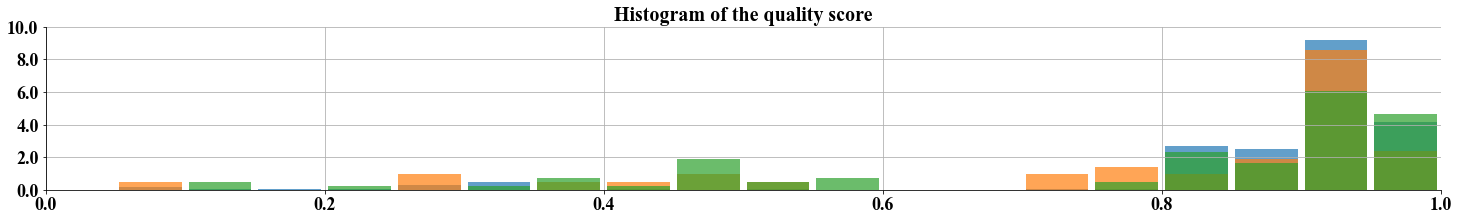

In [72]:
csfont = {'fontname':'Times New Roman'}
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score[idx_nt], density=True, color='tab:blue', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)
plt.hist(weighted_confidence_score[idx_asd], density=True,color='tab:orange', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)
plt.hist(weighted_confidence_score[idx_ddld],density=True, color='tab:green', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')
None

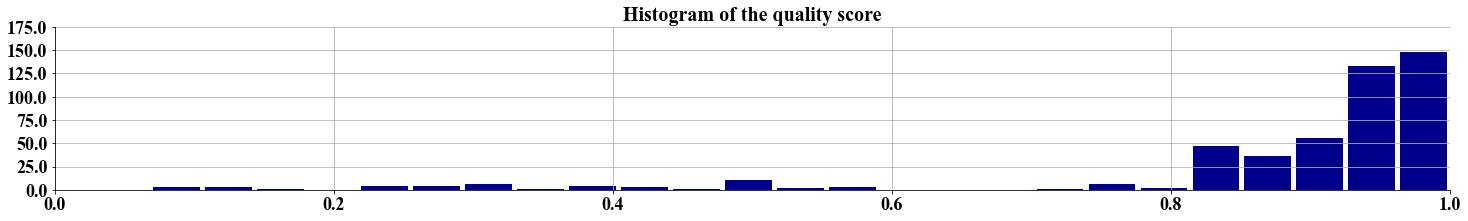

In [43]:
csfont = {'fontname':'Times New Roman'}
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score.flatten(), color='darkblue', bins=25, rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')
None

# Experiemnt NT vs DDLD

In [ ]:
scenario = 'multimodal_2023_regular_ddld_only'


use_weight = False
if use_weight:
    
    df =  pd.read_csv(AUTISM_DATA_PATH)

    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)))
else:
    weighted_confidence_score = None
    
    
K = 1000

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = scenario,
                   positive_class = [2],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_final_nt_ddld', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    

Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0,0.566,0.358,0.254,0.064,0.868,0.599,0.041,0.599,0.096,0.768,0.206,0.214,0.933,0.488,0.064,0.799,0.786,0.512,0.201,21,306,22,77


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,1,0.604,0.416,0.4,0.141,NaN,0.603,0.041,0.603,0.097,0.695,0.186,0.418,0.777,0.36,0.038,0.817,0.582,0.64,0.183,41,255,73,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,2,0.542,0.36,0.227,0.133,0.906,0.603,0.041,0.603,0.097,0.671,0.141,0.398,0.753,0.325,0.033,0.807,0.602,0.675,0.193,39,247,81,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,3,0.535,0.36,0.138,0.129,0.909,0.605,0.042,0.605,0.098,0.793,0.274,0.153,0.985,0.75,0.176,0.796,0.847,0.25,0.204,15,323,5,83


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 5!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,4,0.611,0.413,0.339,0.152,0.941,0.604,0.044,0.604,0.103,0.585,0.159,0.612,0.576,0.302,0.03,0.833,0.388,0.698,0.167,60,189,139,38


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 6!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,5,0.612,0.403,0.432,0.131,0.926,0.601,0.041,0.601,0.097,0.657,0.21,0.551,0.689,0.346,0.036,0.837,0.449,0.654,0.163,54,226,102,44


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,6,0.586,0.408,0.339,0.168,0.941,0.608,0.042,0.608,0.099,0.749,0.197,0.276,0.89,0.429,0.051,0.804,0.724,0.571,0.196,27,292,36,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,7,0.619,0.392,0.323,0.124,0.922,0.601,0.044,0.601,0.103,0.62,0.17,0.561,0.637,0.316,0.032,0.829,0.439,0.684,0.171,55,209,119,43


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,8,0.592,0.394,0.4,0.085,0.888,0.6,0.041,0.6,0.096,0.728,0.22,0.388,0.829,0.404,0.046,0.819,0.612,0.596,0.181,38,272,56,60


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,9,0.629,0.433,0.49,0.136,NaN,0.601,0.041,0.601,0.097,0.751,0.251,0.367,0.866,0.45,0.055,0.821,0.633,0.55,0.179,36,284,44,62


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,10,0.566,0.388,0.317,0.138,NaN,0.6,0.041,0.6,0.097,0.669,0.162,0.439,0.738,0.333,0.034,0.815,0.561,0.667,0.185,43,242,86,55


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,11,0.602,0.406,0.333,0.143,0.937,0.6,0.041,0.6,0.096,0.545,0.152,0.673,0.506,0.289,0.028,0.838,0.327,0.711,0.162,66,166,162,32


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,12,0.586,0.4,0.291,0.165,0.934,0.606,0.042,0.606,0.099,0.803,0.329,0.163,0.994,0.889,0.363,0.799,0.837,0.111,0.201,16,326,2,82


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,13,0.541,0.355,0.208,0.098,0.898,0.6,0.041,0.6,0.096,0.791,0.264,0.163,0.979,0.696,0.14,0.797,0.837,0.304,0.203,16,321,7,82


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,14,0.583,0.359,0.238,0.068,0.865,0.608,0.042,0.608,0.099,0.561,0.133,0.612,0.546,0.287,0.028,0.825,0.388,0.713,0.175,60,179,149,38


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,15,0.623,0.408,0.402,0.091,0.893,0.612,0.043,0.612,0.101,0.603,0.157,0.571,0.613,0.306,0.03,0.827,0.429,0.694,0.173,56,201,127,42


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,16,0.596,0.408,0.403,0.117,0.935,0.6,0.041,0.6,0.097,0.77,0.244,0.276,0.918,0.5,0.066,0.809,0.724,0.5,0.191,27,301,27,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,17,0.535,0.362,0.183,0.088,0.891,0.603,0.041,0.603,0.097,0.782,0.238,0.194,0.957,0.576,0.088,0.799,0.806,0.424,0.201,19,314,14,79


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,18,0.601,0.402,0.375,0.13,0.935,0.6,0.041,0.6,0.096,0.763,0.216,0.255,0.915,0.472,0.06,0.804,0.745,0.528,0.196,25,300,28,73


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,19,0.621,0.409,0.369,0.125,0.935,0.605,0.044,0.605,0.103,0.615,0.194,0.612,0.616,0.323,0.033,0.842,0.388,0.677,0.158,60,202,126,38


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,20,0.556,0.383,0.241,0.157,0.927,0.6,0.041,0.6,0.096,0.739,0.171,0.265,0.881,0.4,0.045,0.801,0.735,0.6,0.199,26,289,39,72


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,21,0.61,0.391,0.309,0.144,0.92,0.603,0.041,0.603,0.097,0.617,0.185,0.592,0.625,0.32,0.032,0.837,0.408,0.68,0.163,58,205,123,40


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,22,0.592,0.399,0.35,0.143,0.934,0.599,0.041,0.599,0.096,0.702,0.173,0.378,0.799,0.359,0.038,0.811,0.622,0.641,0.189,37,262,66,61


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,23,0.599,0.394,0.283,0.13,0.929,0.606,0.043,0.606,0.102,0.603,0.133,0.531,0.625,0.297,0.029,0.817,0.469,0.703,0.183,52,205,123,46


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,24,0.574,0.419,0.325,0.188,0.946,0.601,0.041,0.601,0.097,0.805,0.338,0.204,0.985,0.8,0.221,0.805,0.796,0.2,0.195,20,323,5,78


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,25,0.603,0.396,0.326,0.146,0.928,0.602,0.041,0.602,0.097,0.498,0.146,0.745,0.424,0.279,0.027,0.848,0.255,0.721,0.152,73,139,189,25


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,26,0.589,0.368,0.313,0.068,0.869,0.599,0.042,0.599,0.098,0.648,0.169,0.5,0.692,0.327,0.033,0.822,0.5,0.673,0.178,49,227,101,49


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,27,0.613,0.39,0.377,0.11,0.918,0.599,0.041,0.599,0.096,0.657,0.17,0.48,0.71,0.331,0.034,0.82,0.52,0.669,0.18,47,233,95,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,28,0.618,0.397,0.36,0.082,0.888,0.605,0.042,0.605,0.098,0.685,0.184,0.439,0.759,0.352,0.037,0.819,0.561,0.648,0.181,43,249,79,55


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,29,0.597,0.405,0.369,0.132,0.936,0.602,0.045,0.602,0.105,0.751,0.207,0.286,0.89,0.438,0.052,0.807,0.714,0.562,0.193,28,292,36,70


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,30,0.593,0.405,0.354,0.137,0.938,0.6,0.041,0.6,0.097,0.542,0.149,0.673,0.503,0.288,0.028,0.838,0.327,0.712,0.162,66,165,163,32


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,31,0.572,0.389,0.265,0.13,0.93,0.606,0.042,0.606,0.098,0.746,0.192,0.276,0.887,0.422,0.049,0.804,0.724,0.578,0.196,27,291,37,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,32,0.58,0.378,0.339,0.103,0.913,0.599,0.041,0.599,0.096,0.716,0.212,0.408,0.808,0.388,0.043,0.82,0.592,0.612,0.18,40,265,63,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,33,0.602,0.419,0.416,0.14,0.944,0.601,0.043,0.601,0.101,0.772,0.255,0.286,0.918,0.509,0.069,0.811,0.714,0.491,0.189,28,301,27,70


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,34,0.59,0.399,0.346,0.139,0.934,0.599,0.041,0.599,0.096,0.62,0.17,0.561,0.637,0.316,0.032,0.829,0.439,0.684,0.171,55,209,119,43


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,35,0.581,0.366,0.313,0.058,0.877,0.603,0.041,0.603,0.097,0.763,0.211,0.245,0.918,0.471,0.059,0.803,0.755,0.529,0.197,24,301,27,74


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,36,0.575,0.407,0.318,0.163,0.941,0.6,0.041,0.6,0.096,0.775,0.236,0.235,0.936,0.523,0.072,0.804,0.765,0.477,0.196,23,307,21,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,37,0.596,0.419,0.419,0.149,NaN,0.6,0.041,0.6,0.096,0.746,0.226,0.337,0.869,0.434,0.052,0.814,0.663,0.566,0.186,33,285,43,65


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,38,0.569,0.383,0.246,0.115,0.924,0.6,0.041,0.6,0.096,0.77,0.212,0.214,0.936,0.5,0.066,0.799,0.786,0.5,0.201,21,307,21,77


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,39,0.591,0.401,0.342,0.136,0.936,0.605,0.042,0.605,0.098,0.756,0.212,0.276,0.899,0.45,0.055,0.806,0.724,0.55,0.194,27,295,33,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,40,0.566,0.369,0.181,0.149,0.911,0.6,0.041,0.6,0.096,0.796,0.289,0.133,0.994,0.867,0.316,0.793,0.867,0.133,0.207,13,326,2,85


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,41,0.57,0.366,0.285,0.114,0.909,0.599,0.041,0.599,0.096,0.66,0.131,0.408,0.735,0.315,0.032,0.806,0.592,0.685,0.194,40,241,87,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,42,0.541,0.34,0.149,0.063,0.856,0.6,0.041,0.6,0.096,0.777,0.201,0.153,0.963,0.556,0.082,0.792,0.847,0.444,0.208,15,316,12,83


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,43,0.579,0.393,0.252,0.164,0.929,0.6,0.041,0.6,0.097,0.563,0.16,0.653,0.537,0.296,0.029,0.838,0.347,0.704,0.162,64,176,152,34


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,44,0.57,0.387,0.251,0.167,0.926,0.602,0.041,0.602,0.097,0.669,0.15,0.418,0.744,0.328,0.034,0.811,0.582,0.672,0.189,41,244,84,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,45,0.583,0.382,0.283,0.123,0.922,0.6,0.041,0.6,0.096,0.563,0.136,0.612,0.549,0.288,0.028,0.826,0.388,0.712,0.174,60,180,148,38


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,46,0.573,0.357,0.224,0.087,0.891,0.605,0.042,0.605,0.098,0.559,0.106,0.571,0.555,0.277,0.027,0.812,0.429,0.723,0.188,56,182,146,42


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,47,0.597,0.402,0.328,0.138,0.936,0.603,0.041,0.603,0.098,0.775,0.231,0.224,0.939,0.524,0.073,0.802,0.776,0.476,0.198,22,308,20,76


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,48,0.573,0.387,0.275,0.14,0.928,0.6,0.041,0.6,0.097,0.793,0.278,0.173,0.979,0.708,0.147,0.799,0.827,0.292,0.201,17,321,7,81


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,49,0.564,0.389,0.282,0.139,0.932,0.599,0.041,0.599,0.096,0.716,0.166,0.327,0.832,0.368,0.04,0.805,0.673,0.632,0.195,32,273,55,66


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 51!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,50,0.624,0.412,0.397,0.136,0.937,0.613,0.048,0.613,0.112,0.62,0.158,0.541,0.643,0.312,0.031,0.824,0.459,0.688,0.176,53,211,117,45


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 52!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,51,0.571,0.39,0.268,0.162,0.929,0.601,0.041,0.601,0.097,0.669,0.15,0.418,0.744,0.328,0.034,0.811,0.582,0.672,0.189,41,244,84,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 53!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,52,0.589,0.403,0.357,0.157,0.937,0.6,0.041,0.6,0.096,0.707,0.175,0.367,0.808,0.364,0.039,0.81,0.633,0.636,0.19,36,265,63,62


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 54!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,53,0.547,0.359,0.2,0.114,0.909,0.6,0.041,0.6,0.096,0.739,0.152,0.235,0.89,0.39,0.043,0.796,0.765,0.61,0.204,23,292,36,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 55!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,54,0.603,0.387,0.41,0.08,0.879,0.603,0.041,0.603,0.098,0.671,0.177,0.459,0.735,0.341,0.035,0.82,0.541,0.659,0.18,45,241,87,53


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 56!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,55,0.58,0.384,0.27,0.135,0.925,0.599,0.041,0.599,0.096,0.779,0.23,0.194,0.954,0.559,0.083,0.798,0.806,0.441,0.202,19,313,15,79


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 57!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,56,0.586,0.4,0.291,0.165,0.934,0.606,0.042,0.606,0.099,0.803,0.329,0.163,0.994,0.889,0.363,0.799,0.837,0.111,0.201,16,326,2,82


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 58!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,57,0.618,0.422,0.422,0.131,0.943,0.6,0.041,0.6,0.097,0.638,0.187,0.551,0.665,0.329,0.034,0.832,0.449,0.671,0.168,54,218,110,44


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 59!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,58,0.556,0.384,0.211,0.131,0.928,0.606,0.042,0.606,0.098,0.791,0.27,0.184,0.973,0.667,0.124,0.799,0.816,0.333,0.201,18,319,9,80


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 60!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,59,0.576,0.394,0.296,0.145,0.934,0.603,0.045,0.603,0.104,0.775,0.22,0.204,0.945,0.526,0.073,0.799,0.796,0.474,0.201,20,310,18,78


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 61!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,60,0.599,0.399,0.349,0.143,NaN,0.601,0.041,0.601,0.097,0.718,0.17,0.327,0.835,0.372,0.04,0.806,0.673,0.628,0.194,32,274,54,66


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 62!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,61,0.586,0.424,0.419,0.176,NaN,0.601,0.041,0.601,0.097,0.73,0.224,0.388,0.832,0.409,0.047,0.82,0.612,0.591,0.18,38,273,55,60


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 63!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,62,0.569,0.373,0.257,0.122,0.916,0.605,0.042,0.605,0.098,0.798,0.306,0.133,0.997,0.929,0.48,0.794,0.867,0.071,0.206,13,327,1,85


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 64!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,63,0.582,0.373,0.291,0.069,0.882,0.604,0.042,0.604,0.098,0.779,0.23,0.194,0.954,0.559,0.083,0.798,0.806,0.441,0.202,19,313,15,79


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 65!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,64,0.613,0.389,0.331,0.104,0.916,0.6,0.041,0.6,0.096,0.676,0.177,0.449,0.744,0.344,0.036,0.819,0.551,0.656,0.181,44,244,84,54


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 66!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,65,0.603,0.403,0.332,0.138,0.936,0.608,0.043,0.608,0.1,0.446,0.146,0.827,0.332,0.27,0.026,0.865,0.173,0.73,0.135,81,109,219,17


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 67!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,66,0.554,0.374,0.161,0.158,0.917,0.601,0.041,0.601,0.097,0.796,0.287,0.143,0.991,0.824,0.249,0.795,0.857,0.176,0.205,14,325,3,84


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 68!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,67,0.589,0.384,0.305,0.116,0.919,0.603,0.041,0.603,0.097,0.627,0.132,0.48,0.671,0.303,0.03,0.812,0.52,0.697,0.188,47,220,108,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 69!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,68,0.567,0.391,0.28,0.159,0.932,0.6,0.041,0.6,0.096,0.746,0.186,0.265,0.89,0.419,0.049,0.802,0.735,0.581,0.198,26,292,36,72


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 70!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,69,0.6,0.398,0.314,0.15,0.93,0.599,0.041,0.599,0.096,0.648,0.158,0.48,0.698,0.322,0.033,0.818,0.52,0.678,0.182,47,229,99,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 71!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,70,0.58,0.404,0.317,0.138,0.938,0.599,0.041,0.599,0.096,0.775,0.231,0.224,0.939,0.524,0.073,0.802,0.776,0.476,0.198,22,308,20,76


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 72!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,71,0.585,0.392,0.342,0.129,0.93,0.609,0.044,0.609,0.103,0.728,0.192,0.337,0.845,0.393,0.044,0.81,0.663,0.607,0.19,33,277,51,65


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 73!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,72,0.611,0.427,0.459,0.17,0.947,0.602,0.042,0.602,0.099,0.723,0.224,0.408,0.817,0.4,0.045,0.822,0.592,0.6,0.178,40,268,60,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 74!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,73,0.625,0.436,0.486,0.158,0.949,0.608,0.046,0.608,0.106,0.744,0.27,0.429,0.838,0.442,0.053,0.831,0.571,0.558,0.169,42,275,53,56


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 75!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,74,0.605,0.396,0.397,0.107,0.923,0.612,0.043,0.612,0.102,0.587,0.156,0.602,0.582,0.301,0.03,0.83,0.398,0.699,0.17,59,191,137,39


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 76!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,75,0.549,0.349,0.061,0.132,0.885,0.604,0.044,0.604,0.103,0.791,0.259,0.133,0.988,0.765,0.188,0.792,0.867,0.235,0.208,13,324,4,85


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 77!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,76,0.574,0.376,0.307,0.1,0.915,0.599,0.041,0.599,0.096,0.739,0.171,0.265,0.881,0.4,0.045,0.801,0.735,0.6,0.199,26,289,39,72


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 78!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,77,0.595,0.397,0.301,0.146,0.932,0.602,0.041,0.602,0.097,0.655,0.155,0.459,0.713,0.324,0.033,0.815,0.541,0.676,0.185,45,234,94,53


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 79!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,78,0.612,0.416,0.387,0.172,0.941,0.602,0.042,0.602,0.099,0.723,0.195,0.357,0.832,0.389,0.043,0.812,0.643,0.611,0.188,35,273,55,63


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 80!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,79,0.596,0.398,0.317,0.131,0.931,0.603,0.041,0.603,0.098,0.77,0.239,0.265,0.921,0.5,0.066,0.807,0.735,0.5,0.193,26,302,26,72


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 81!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,80,0.601,0.409,0.373,0.136,0.939,0.608,0.043,0.608,0.1,0.667,0.176,0.469,0.726,0.338,0.035,0.821,0.531,0.662,0.179,46,238,90,52


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 82!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,81,0.58,0.403,0.361,0.158,0.938,0.6,0.041,0.6,0.097,0.768,0.223,0.245,0.924,0.49,0.064,0.804,0.755,0.51,0.196,24,303,25,74


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 83!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,82,0.569,0.391,0.28,0.163,0.931,0.599,0.041,0.599,0.096,0.685,0.143,0.367,0.78,0.333,0.034,0.805,0.633,0.667,0.195,36,256,72,62


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 84!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,83,0.59,0.382,0.38,0.084,0.895,0.6,0.041,0.6,0.096,0.763,0.228,0.276,0.909,0.474,0.06,0.808,0.724,0.526,0.192,27,298,30,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 85!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,84,0.601,0.405,0.362,0.139,0.938,0.604,0.042,0.604,0.098,0.723,0.19,0.347,0.835,0.386,0.043,0.811,0.653,0.614,0.189,34,274,54,64


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 86!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,85,0.574,0.391,0.238,0.165,0.929,0.601,0.041,0.601,0.097,0.8,0.316,0.153,0.994,0.882,0.348,0.797,0.847,0.118,0.203,15,326,2,83


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 87!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,86,0.578,0.383,0.197,0.166,0.92,0.6,0.041,0.6,0.097,0.751,0.184,0.245,0.902,0.429,0.051,0.8,0.755,0.571,0.2,24,296,32,74


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 88!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,87,0.57,0.396,0.279,0.155,0.935,0.609,0.044,0.609,0.102,0.777,0.243,0.235,0.939,0.535,0.076,0.804,0.765,0.465,0.196,23,308,20,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 89!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,88,0.628,0.419,0.428,0.159,NaN,0.601,0.041,0.601,0.097,0.711,0.199,0.398,0.805,0.379,0.042,0.817,0.602,0.621,0.183,39,264,64,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 90!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,89,0.613,0.407,0.359,0.145,0.936,0.602,0.041,0.602,0.097,0.599,0.163,0.592,0.601,0.307,0.031,0.831,0.408,0.693,0.169,58,197,131,40


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 91!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,90,0.631,0.416,0.428,0.128,0.936,0.619,0.045,0.619,0.106,0.714,0.214,0.418,0.802,0.387,0.043,0.822,0.582,0.613,0.178,41,263,65,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 92!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,91,0.539,0.362,0.052,0.159,NaN,0.608,0.043,0.608,0.102,0.8,0.319,0.143,0.997,0.933,0.499,0.796,0.857,0.067,0.204,14,327,1,84


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 93!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,92,0.565,0.383,0.206,0.133,NaN,0.6,0.041,0.6,0.097,0.796,0.288,0.163,0.985,0.762,0.185,0.798,0.837,0.238,0.202,16,323,5,82


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 94!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,93,0.626,0.418,0.423,0.117,0.937,0.604,0.042,0.604,0.099,0.627,0.19,0.582,0.64,0.326,0.033,0.837,0.418,0.674,0.163,57,210,118,41


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 95!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,94,0.564,0.392,0.275,0.149,0.931,0.602,0.041,0.602,0.097,0.671,0.159,0.429,0.744,0.333,0.034,0.813,0.571,0.667,0.187,42,244,84,56


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 96!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,95,0.582,0.425,0.373,0.187,0.949,0.601,0.042,0.601,0.099,0.779,0.264,0.265,0.933,0.542,0.078,0.81,0.735,0.458,0.19,26,306,22,72


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 97!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,96,0.568,0.373,0.228,0.144,0.917,0.599,0.041,0.599,0.096,0.793,0.273,0.133,0.991,0.812,0.236,0.793,0.867,0.188,0.207,13,325,3,85


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 98!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,97,0.582,0.415,0.408,0.165,0.944,0.599,0.041,0.599,0.096,0.763,0.249,0.316,0.896,0.477,0.061,0.814,0.684,0.523,0.186,31,294,34,67


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 99!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,98,0.601,0.404,0.322,0.134,0.935,0.599,0.041,0.599,0.096,0.678,0.157,0.408,0.759,0.336,0.035,0.811,0.592,0.664,0.189,40,249,79,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 100!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,99,0.589,0.392,0.34,0.134,NaN,0.604,0.042,0.604,0.098,0.662,0.164,0.459,0.723,0.331,0.034,0.817,0.541,0.669,0.183,45,237,91,53


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 101!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,100,0.606,0.416,0.434,0.153,0.942,0.605,0.043,0.605,0.102,0.763,0.244,0.306,0.899,0.476,0.061,0.813,0.694,0.524,0.187,30,295,33,68


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 102!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,101,0.576,0.395,0.358,0.114,0.931,0.602,0.041,0.602,0.097,0.754,0.218,0.296,0.89,0.446,0.054,0.809,0.704,0.554,0.191,29,292,36,69


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 103!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,102,0.633,0.428,0.425,0.17,0.945,0.61,0.043,0.61,0.1,0.648,0.215,0.582,0.668,0.343,0.036,0.842,0.418,0.657,0.158,57,219,109,41


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 104!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,103,0.581,0.393,0.304,0.147,0.932,0.601,0.041,0.601,0.097,0.709,0.166,0.347,0.817,0.362,0.039,0.807,0.653,0.638,0.193,34,268,60,64


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 105!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,104,0.543,0.365,0.166,0.132,0.915,0.605,0.042,0.605,0.098,0.772,0.196,0.173,0.951,0.515,0.07,0.794,0.827,0.485,0.206,17,312,16,81


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 106!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,105,0.624,0.439,0.467,0.176,NaN,0.603,0.041,0.603,0.098,0.629,0.181,0.561,0.649,0.324,0.033,0.832,0.439,0.676,0.168,55,213,115,43


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 107!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,106,0.604,0.407,0.378,0.164,0.934,0.611,0.044,0.611,0.103,0.707,0.192,0.398,0.799,0.371,0.04,0.816,0.602,0.629,0.184,39,262,66,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 108!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,107,0.583,0.388,0.221,0.139,0.926,0.604,0.042,0.604,0.098,0.516,0.14,0.704,0.46,0.28,0.027,0.839,0.296,0.72,0.161,69,151,177,29


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 109!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,108,0.563,0.402,0.288,0.162,0.939,0.6,0.041,0.6,0.096,0.798,0.303,0.194,0.979,0.731,0.162,0.802,0.806,0.269,0.198,19,321,7,79


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 110!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,109,0.567,0.391,0.274,0.159,0.93,0.6,0.041,0.6,0.097,0.667,0.147,0.418,0.741,0.325,0.033,0.81,0.582,0.675,0.19,41,243,85,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 111!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,110,0.606,0.396,0.286,0.133,0.929,0.603,0.041,0.603,0.098,0.566,0.156,0.643,0.543,0.296,0.029,0.836,0.357,0.704,0.164,63,178,150,35


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 112!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,111,0.535,0.362,0.183,0.088,0.891,0.603,0.041,0.603,0.097,0.782,0.238,0.194,0.957,0.576,0.088,0.799,0.806,0.424,0.201,19,314,14,79


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 113!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,112,0.601,0.418,0.376,0.147,0.944,0.602,0.042,0.602,0.099,0.646,0.161,0.49,0.692,0.322,0.033,0.819,0.51,0.678,0.181,48,227,101,50


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 114!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,113,0.589,0.407,0.355,0.142,0.939,0.6,0.041,0.6,0.097,0.725,0.182,0.327,0.845,0.386,0.043,0.808,0.673,0.614,0.192,32,277,51,66


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 115!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,114,0.61,0.415,0.36,0.166,0.942,0.602,0.042,0.602,0.099,0.638,0.146,0.48,0.686,0.313,0.031,0.815,0.52,0.687,0.185,47,225,103,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 116!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,115,0.61,0.417,0.397,0.153,0.942,0.6,0.041,0.6,0.097,0.7,0.21,0.449,0.774,0.373,0.041,0.825,0.551,0.627,0.175,44,254,74,54


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 117!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,116,0.575,0.375,0.298,0.105,0.917,0.6,0.041,0.6,0.096,0.735,0.175,0.286,0.869,0.394,0.044,0.803,0.714,0.606,0.197,28,285,43,70


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 118!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,117,0.554,0.351,0.236,0.098,0.895,0.6,0.041,0.6,0.097,0.709,0.142,0.306,0.829,0.349,0.037,0.8,0.694,0.651,0.2,30,272,56,68


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 119!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,118,0.582,0.388,0.345,0.117,0.926,0.599,0.041,0.599,0.096,0.735,0.21,0.347,0.851,0.41,0.047,0.813,0.653,0.59,0.187,34,279,49,64


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 120!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,119,0.602,0.423,0.42,0.162,0.946,0.6,0.041,0.6,0.096,0.714,0.209,0.408,0.805,0.385,0.043,0.82,0.592,0.615,0.18,40,264,64,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 121!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,120,0.575,0.394,0.376,0.146,0.931,0.6,0.041,0.6,0.097,0.725,0.199,0.357,0.835,0.393,0.044,0.813,0.643,0.607,0.187,35,274,54,63


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 122!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,121,0.557,0.404,0.277,0.164,0.94,0.6,0.041,0.6,0.096,0.791,0.28,0.214,0.963,0.636,0.111,0.804,0.786,0.364,0.196,21,316,12,77


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 123!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,122,0.565,0.408,0.323,0.157,0.942,0.6,0.041,0.6,0.096,0.782,0.257,0.235,0.945,0.561,0.083,0.805,0.765,0.439,0.195,23,310,18,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 124!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,123,0.578,0.387,0.325,0.1,0.902,0.602,0.041,0.602,0.097,0.681,0.154,0.398,0.765,0.336,0.035,0.81,0.602,0.664,0.19,39,251,77,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 125!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,124,0.559,0.375,0.203,0.122,NaN,0.6,0.041,0.6,0.096,0.777,0.228,0.204,0.948,0.541,0.077,0.799,0.796,0.459,0.201,20,311,17,78


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 126!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,125,0.605,0.401,0.304,0.168,0.932,0.619,0.044,0.619,0.103,0.69,0.15,0.367,0.787,0.34,0.035,0.806,0.633,0.66,0.194,36,258,70,62


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 127!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,126,0.582,0.411,0.32,0.18,0.94,0.604,0.043,0.604,0.1,0.709,0.196,0.398,0.802,0.375,0.041,0.817,0.602,0.625,0.183,39,263,65,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 128!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,127,0.614,0.412,0.429,0.149,0.938,0.612,0.045,0.612,0.106,0.777,0.262,0.276,0.927,0.529,0.074,0.811,0.724,0.471,0.189,27,304,24,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 129!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,128,0.61,0.391,0.309,0.144,0.92,0.603,0.041,0.603,0.097,0.617,0.185,0.592,0.625,0.32,0.032,0.837,0.408,0.68,0.163,58,205,123,40


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 130!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,129,0.577,0.371,0.279,0.12,0.911,0.603,0.041,0.603,0.097,0.627,0.126,0.469,0.674,0.301,0.03,0.81,0.531,0.699,0.19,46,221,107,52


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 131!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,130,0.568,0.366,0.199,0.121,0.91,0.599,0.041,0.599,0.096,0.622,0.126,0.48,0.665,0.299,0.029,0.81,0.52,0.701,0.19,47,218,110,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 132!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,131,0.582,0.391,0.299,0.144,0.929,0.6,0.041,0.6,0.096,0.549,0.138,0.643,0.521,0.286,0.028,0.83,0.357,0.714,0.17,63,171,157,35


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 133!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,132,0.547,0.359,0.2,0.114,0.909,0.6,0.041,0.6,0.096,0.739,0.152,0.235,0.89,0.39,0.043,0.796,0.765,0.61,0.204,23,292,36,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 134!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,133,0.628,0.438,0.455,0.165,0.952,0.605,0.045,0.605,0.105,0.775,0.266,0.296,0.918,0.518,0.071,0.814,0.704,0.482,0.186,29,301,27,69


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 135!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,134,0.62,0.41,0.365,0.151,0.936,0.601,0.041,0.601,0.097,0.566,0.174,0.673,0.534,0.301,0.03,0.845,0.327,0.699,0.155,66,175,153,32


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 136!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,135,0.573,0.384,0.311,0.112,NaN,0.6,0.041,0.6,0.097,0.707,0.169,0.357,0.811,0.361,0.039,0.809,0.643,0.639,0.191,35,266,62,63


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 137!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,136,0.609,0.39,0.379,0.126,0.922,0.612,0.043,0.612,0.101,0.655,0.172,0.49,0.704,0.331,0.034,0.822,0.51,0.669,0.178,48,231,97,50


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 138!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,137,0.549,0.393,0.322,0.101,0.909,0.601,0.042,0.601,0.098,0.779,0.25,0.235,0.942,0.548,0.079,0.805,0.765,0.452,0.195,23,309,19,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 139!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,138,0.632,0.41,0.38,0.145,0.935,0.613,0.047,0.613,0.109,0.556,0.183,0.704,0.512,0.301,0.03,0.853,0.296,0.699,0.147,69,168,160,29


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 140!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,139,0.609,0.406,0.388,0.147,0.936,0.604,0.042,0.604,0.098,0.714,0.192,0.378,0.814,0.378,0.041,0.814,0.622,0.622,0.186,37,267,61,61


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 141!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,140,0.602,0.424,0.406,0.176,0.948,0.602,0.042,0.602,0.098,0.702,0.197,0.418,0.787,0.369,0.04,0.819,0.582,0.631,0.181,41,258,70,57


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 142!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,141,0.602,0.411,0.34,0.136,0.939,0.6,0.041,0.6,0.096,0.77,0.229,0.245,0.927,0.5,0.066,0.804,0.755,0.5,0.196,24,304,24,74


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 143!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,142,0.582,0.398,0.389,0.082,0.888,0.6,0.041,0.6,0.097,0.772,0.265,0.306,0.912,0.508,0.069,0.815,0.694,0.492,0.185,30,299,29,68


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 144!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,143,0.585,0.407,0.384,0.124,0.937,0.6,0.042,0.6,0.098,0.669,0.179,0.469,0.729,0.341,0.035,0.821,0.531,0.659,0.179,46,239,89,52


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 145!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,144,0.574,0.419,0.325,0.188,0.946,0.601,0.041,0.601,0.097,0.805,0.338,0.204,0.985,0.8,0.221,0.805,0.796,0.2,0.195,20,323,5,78


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 146!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,145,0.58,0.395,0.332,0.128,0.93,0.604,0.042,0.604,0.098,0.728,0.174,0.306,0.854,0.385,0.043,0.805,0.694,0.615,0.195,30,280,48,68


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 147!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,146,0.595,0.396,0.297,0.162,0.928,0.6,0.041,0.6,0.097,0.657,0.14,0.429,0.726,0.318,0.032,0.81,0.571,0.682,0.19,42,238,90,56


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 148!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,147,0.589,0.407,0.355,0.142,0.939,0.6,0.041,0.6,0.097,0.725,0.182,0.327,0.845,0.386,0.043,0.808,0.673,0.614,0.192,32,277,51,66


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 149!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,148,0.534,0.387,0.191,0.164,0.931,0.599,0.041,0.599,0.096,0.803,0.327,0.173,0.991,0.85,0.287,0.8,0.827,0.15,0.2,17,325,3,81


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 150!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,149,0.592,0.409,0.334,0.172,0.94,0.614,0.046,0.614,0.107,0.784,0.264,0.235,0.948,0.575,0.088,0.806,0.765,0.425,0.194,23,311,17,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 151!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,150,0.61,0.415,0.36,0.166,0.942,0.602,0.042,0.602,0.099,0.638,0.146,0.48,0.686,0.313,0.031,0.815,0.52,0.687,0.185,47,225,103,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 152!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,151,0.605,0.396,0.397,0.107,0.923,0.612,0.043,0.612,0.102,0.587,0.156,0.602,0.582,0.301,0.03,0.83,0.398,0.699,0.17,59,191,137,39


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 153!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,152,0.597,0.402,0.371,0.141,0.935,0.599,0.041,0.599,0.096,0.683,0.175,0.429,0.759,0.347,0.036,0.816,0.571,0.653,0.184,42,249,79,56


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 154!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,153,0.596,0.406,0.324,0.173,0.936,0.601,0.042,0.601,0.098,0.683,0.158,0.398,0.768,0.339,0.035,0.81,0.602,0.661,0.19,39,252,76,59


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 155!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,154,0.571,0.379,0.25,0.131,0.921,0.6,0.041,0.6,0.097,0.793,0.274,0.153,0.985,0.75,0.176,0.796,0.847,0.25,0.204,15,323,5,83


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 156!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,155,0.598,0.41,0.422,0.135,0.938,0.6,0.041,0.6,0.097,0.716,0.212,0.408,0.808,0.388,0.043,0.82,0.592,0.612,0.18,40,265,63,58


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 157!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,156,0.568,0.375,0.152,0.136,0.917,0.605,0.043,0.605,0.1,0.779,0.225,0.184,0.957,0.562,0.084,0.797,0.816,0.438,0.203,18,314,14,80


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 158!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,157,0.595,0.402,0.322,0.14,0.935,0.602,0.041,0.602,0.097,0.782,0.257,0.235,0.945,0.561,0.083,0.805,0.765,0.439,0.195,23,310,18,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 159!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,158,0.567,0.39,0.316,0.136,0.931,0.606,0.042,0.606,0.099,0.786,0.267,0.224,0.954,0.595,0.094,0.805,0.776,0.405,0.195,22,313,15,76


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 160!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,159,0.589,0.407,0.355,0.142,0.939,0.6,0.041,0.6,0.097,0.725,0.182,0.327,0.845,0.386,0.043,0.808,0.673,0.614,0.192,32,277,51,66


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 161!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,160,0.58,0.386,0.237,0.161,0.922,0.599,0.041,0.599,0.096,0.542,0.125,0.633,0.515,0.281,0.027,0.824,0.367,0.719,0.176,62,169,159,36


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 162!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,161,0.584,0.386,0.28,0.132,0.926,0.599,0.041,0.599,0.096,0.58,0.124,0.561,0.585,0.288,0.028,0.817,0.439,0.712,0.183,55,192,136,43


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 163!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,162,0.576,0.394,0.296,0.145,0.934,0.603,0.045,0.603,0.104,0.775,0.22,0.204,0.945,0.526,0.073,0.799,0.796,0.474,0.201,20,310,18,78


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 164!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,163,0.603,0.407,0.393,0.155,0.938,0.6,0.041,0.6,0.096,0.742,0.2,0.306,0.872,0.417,0.048,0.808,0.694,0.583,0.192,30,286,42,68


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 165!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,164,0.582,0.395,0.28,0.149,0.933,0.606,0.044,0.606,0.103,0.784,0.242,0.184,0.963,0.6,0.096,0.798,0.816,0.4,0.202,18,316,12,80


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 166!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,165,0.591,0.408,0.345,0.159,0.941,0.603,0.041,0.603,0.097,0.657,0.158,0.459,0.716,0.326,0.033,0.816,0.541,0.674,0.184,45,235,93,53


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 167!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,166,0.568,0.366,0.199,0.121,0.91,0.599,0.041,0.599,0.096,0.622,0.126,0.48,0.665,0.299,0.029,0.81,0.52,0.701,0.19,47,218,110,51


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 168!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,167,0.558,0.361,0.183,0.089,0.885,0.6,0.041,0.6,0.097,0.791,0.26,0.143,0.985,0.737,0.166,0.794,0.857,0.263,0.206,14,323,5,84


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 169!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,168,0.604,0.413,0.372,0.162,0.941,0.6,0.041,0.6,0.097,0.716,0.184,0.357,0.823,0.376,0.041,0.811,0.643,0.624,0.189,35,270,58,63


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 170!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,169,0.561,0.359,0.239,0.113,0.904,0.6,0.041,0.6,0.096,0.718,0.151,0.296,0.845,0.362,0.039,0.801,0.704,0.638,0.199,29,277,51,69


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 171!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,170,0.569,0.377,0.205,0.119,0.92,0.6,0.041,0.6,0.097,0.791,0.264,0.163,0.979,0.696,0.14,0.797,0.837,0.304,0.203,16,321,7,82


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 172!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,171,0.632,0.433,0.42,0.154,0.948,0.6,0.041,0.6,0.097,0.592,0.185,0.643,0.576,0.312,0.031,0.844,0.357,0.688,0.156,63,189,139,35


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 173!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,172,0.584,0.374,0.269,0.074,0.879,0.603,0.041,0.603,0.097,0.791,0.27,0.184,0.973,0.667,0.124,0.799,0.816,0.333,0.201,18,319,9,80


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 174!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,173,0.617,0.407,0.367,0.129,0.934,0.602,0.042,0.602,0.098,0.646,0.172,0.51,0.686,0.327,0.033,0.824,0.49,0.673,0.176,50,225,103,48


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 175!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,174,0.593,0.392,0.322,0.152,0.928,0.606,0.044,0.606,0.103,0.648,0.152,0.469,0.701,0.319,0.032,0.816,0.531,0.681,0.184,46,230,98,52


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 176!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,175,0.593,0.405,0.354,0.137,0.938,0.6,0.041,0.6,0.097,0.542,0.149,0.673,0.503,0.288,0.028,0.838,0.327,0.712,0.162,66,165,163,32


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 177!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,176,0.582,0.38,0.328,0.09,0.898,0.602,0.041,0.602,0.097,0.746,0.192,0.276,0.887,0.422,0.049,0.804,0.724,0.578,0.196,27,291,37,71


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 178!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,177,0.638,0.423,0.401,0.162,0.942,0.611,0.046,0.611,0.108,0.631,0.201,0.592,0.643,0.331,0.034,0.841,0.408,0.669,0.159,58,211,117,40


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 179!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,178,0.543,0.365,0.166,0.132,0.915,0.605,0.042,0.605,0.098,0.772,0.196,0.173,0.951,0.515,0.07,0.794,0.827,0.485,0.206,17,312,16,81


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 180!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,179,0.588,0.426,0.361,0.195,0.949,0.605,0.042,0.605,0.098,0.782,0.257,0.235,0.945,0.561,0.083,0.805,0.765,0.439,0.195,23,310,18,75


Saving experiment in folder multimodal_paper_final_nt_ddld.
Doing experiment 181!


In [7]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['multimodal_paper_final_nt_ddld'])

100%|██████████| 1001/1001 [06:24<00:00,  2.61it/s]


In [8]:
from utils import compute_performances
performances_df = compute_performances(df)
#performances_df.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/performances_multimodal_paper.csv", index=False)

performances_df 

,name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Corrected NPV,Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN,optimal_threshold,num_samples,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N,y_true,y_pred,Hanley_CI
\n(N=426),\n(N=426),0.651,0.451,0.504,0.182,0.955,0.416,0.069,0.494,0.145,0.66,0.213,0.551,0.692,0.348,0.037,0.986,0.838,0.449,0.652,0.162,54,227,101,44,0.283,426,53.286385,12.676056,23.70892,10.328638,426,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.292, 0.248, 0.127, 0.438, 0.05, 0.036, 0.29...",0.033103


In [9]:
from utils import create_autism_df, compute_performances, bootstrap_sensitivity_specificity
performances_df = compute_performances(df)
 
y_pred = performances_df.iloc[0]['y_pred']
y_true = performances_df.iloc[0]['y_true']
optimal_threshold = performances_df.iloc[0]['optimal_threshold']
bootstrap_sensitivity_specificity(y_true, y_pred, optimal_threshold)

Average Sensitivity: 0.554 +/- 0.052
Average Specificity: 0.688 +/- 0.026


In [ ]:
conslusiveness_score = performances_df.iloc[0]['y_pred']

fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 100 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

In [316]:
from utils import compute_performances_operating_points
df_breakdown_results = compute_performances_operating_points(y_true=y_true, y_pred=conslusiveness_score)

#df_breakdown_results.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/operating_points_multimodal_paper_nt_ddld.csv", index=False)

df_breakdown_results

,Threshold index,Threshold,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0,2.000,0.000000,1.000000,NaN,NaN,0.870027,0.979200
1,1,1.000,0.346939,0.984756,0.772727,0.325894,0.909859,0.986109
2,2,0.999,0.346939,0.978659,0.708333,0.256682,0.909348,0.986023
3,3,0.998,0.367347,0.972561,0.666667,0.221414,0.911429,0.986370
4,4,0.997,0.408163,0.969512,0.666667,0.221414,0.916427,0.987199
...,...,...,...,...,...,...,...,...
66,66,0.004,0.959184,0.457317,0.208889,0.036186,0.986842,0.998108
67,67,0.003,0.959184,0.442073,0.204348,0.035232,0.986395,0.998043
68,68,0.002,0.959184,0.405488,0.194215,0.033136,0.985185,0.997866
69,69,0.001,0.959184,0.375000,0.186508,0.031571,0.984000,0.997693


In [24]:
df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_ddld_nt.csv', index=False)

# ASD+DD/LD vs NT

In [ ]:
scenario = 'multimodal_2023_regular_ddld'


use_weight = False
if use_weight:
    
    df =  pd.read_csv(AUTISM_DATA_PATH)

    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)))
else:
    weighted_confidence_score = None
    
    
K = 1000

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = scenario,
                   positive_class = [1, 2],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_final_nt_ddld_asd', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    

**Analysis**

In [ ]:
df = create_autism_df(folder_names = ['multimodal_paper_final_nt_ddld_asd'])

In [ ]:
from utils import compute_performances
performances_df = compute_performances(df)
#performances_df.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/performances_multimodal_paper.csv", index=False)

performances_df 

In [ ]:
conslusiveness_score = performances_df.iloc[0]['y_pred']

fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 100 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

In [ ]:
from utils import compute_performances_operating_points
df_breakdown_results = compute_performances_operating_points(y_true=y_true, y_pred=conslusiveness_score)

#df_breakdown_results.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/operating_points_multimodal_paper_nt_ddld.csv", index=False)

df_breakdown_results

In [29]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'optimal_threshold'])

metrics_of_interest = ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr', 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV','PPV-Corr', 'NPV', 'NPV Corr']#, 'Precision Corrected']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV', 'NPV']#, 'Precision Corrected']


for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'optimal_threshold': experiment_row['optimal_threshold']
                                                                      }, ignore_index=True)
        

In [30]:
results_df_vertical.groupby(['metric_name']).describe()['score']

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
AUROC,50.0,0.602880,0.013318,0.581,0.595,0.5995,0.611750,0.643000
FN,50.0,2.260000,1.208980,1.000,1.000,2.0000,3.000000,5.000000
FP,50.0,327.260000,2.048494,318.000,327.000,328.0000,328.000000,328.000000
NPV,50.0,0.126040,0.229707,0.000,0.000,0.0000,0.191750,0.833000
NPV Corr,50.0,0.257391,0.418133,0.000,0.000,0.0000,0.819585,0.989728
PPV,50.0,0.306780,0.002150,0.302,0.305,0.3070,0.308000,0.313000
PPV-Corr,50.0,0.022400,0.000495,0.022,0.022,0.0220,0.023000,0.023000
Sensitivity,50.0,0.984540,0.008039,0.966,0.980,0.9860,0.993000,0.993000
Specificity,50.0,0.002220,0.006145,0.000,0.000,0.0000,0.003000,0.030000


In [31]:
df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_ddld+asd_nt.csv', index=False)

# ASD vs DD/LD + NT

In [ ]:
scenario = 'multimodal_2023_regular_ddld'


use_weight = False

if use_weight:
    
    df =  pd.read_csv(AUTISM_DATA_PATH)

    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)))
else:
    weighted_confidence_score = None
    
K = 1000

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = scenario,
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=True,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_final_asd_nasd', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    

Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0,0.848,0.428,0.896,0.159,0.948,0.562,0.117,0.562,0.238,0.697,0.336,0.857,0.678,0.235,0.054,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,1,0.807,0.37,0.853,0.117,0.94,0.556,0.113,0.556,0.232,0.749,0.344,0.776,0.746,0.26,0.061,0.967,0.224,0.74,0.033,38,318,108,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,2,0.826,0.365,0.83,0.101,0.894,0.619,0.15,0.619,0.292,0.811,0.427,0.796,0.812,0.328,0.083,0.972,0.204,0.672,0.028,39,346,80,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,3,0.813,0.361,0.854,0.107,0.932,0.582,0.135,0.582,0.267,0.796,0.387,0.755,0.8,0.303,0.074,0.966,0.245,0.697,0.034,37,341,85,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 5!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,4,0.831,0.406,0.87,0.149,0.951,0.583,0.13,0.583,0.26,0.783,0.382,0.776,0.784,0.292,0.071,0.968,0.224,0.708,0.032,38,334,92,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 6!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,5,0.843,0.428,0.877,0.171,0.968,0.583,0.112,0.583,0.234,0.728,0.365,0.857,0.714,0.256,0.06,0.977,0.143,0.744,0.023,42,304,122,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,6,0.825,0.365,0.85,0.104,0.901,0.567,0.115,0.567,0.236,0.749,0.355,0.796,0.744,0.264,0.062,0.969,0.204,0.736,0.031,39,317,109,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,7,0.831,0.386,0.867,0.116,0.934,0.615,0.147,0.615,0.287,0.806,0.421,0.796,0.808,0.322,0.081,0.972,0.204,0.678,0.028,39,344,82,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,8,0.814,0.375,0.851,0.117,0.94,0.565,0.137,0.565,0.266,0.804,0.377,0.714,0.815,0.307,0.076,0.961,0.286,0.693,0.039,35,347,79,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,9,0.83,0.422,0.859,0.169,0.964,0.592,0.152,0.592,0.289,0.777,0.385,0.796,0.775,0.289,0.07,0.971,0.204,0.711,0.029,39,330,96,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,10,0.783,0.341,0.841,0.099,0.925,0.518,0.098,0.518,0.205,0.714,0.298,0.755,0.709,0.23,0.052,0.962,0.245,0.77,0.038,37,302,124,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,11,0.825,0.388,0.869,0.13,0.91,0.557,0.125,0.557,0.248,0.781,0.358,0.735,0.786,0.283,0.068,0.963,0.265,0.717,0.037,36,335,91,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,12,0.829,0.359,0.807,0.112,0.898,0.566,0.104,0.566,0.219,0.705,0.344,0.857,0.688,0.24,0.055,0.977,0.143,0.76,0.023,42,293,133,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,13,0.846,0.472,0.916,0.242,0.984,0.597,0.115,0.597,0.24,0.733,0.38,0.878,0.716,0.262,0.062,0.981,0.122,0.738,0.019,43,305,121,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,14,0.846,0.422,0.853,0.167,0.966,0.623,0.171,0.623,0.319,0.796,0.418,0.816,0.793,0.312,0.077,0.974,0.184,0.688,0.026,40,338,88,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,15,0.829,0.418,0.87,0.172,0.972,0.604,0.133,0.604,0.267,0.781,0.4,0.816,0.777,0.296,0.072,0.974,0.184,0.704,0.026,40,331,95,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,16,0.84,0.429,0.886,0.174,0.97,0.589,0.119,0.589,0.245,0.749,0.376,0.837,0.739,0.27,0.064,0.975,0.163,0.73,0.025,41,315,111,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,17,0.835,0.452,0.908,0.189,0.969,0.58,0.104,0.58,0.222,0.697,0.357,0.898,0.674,0.24,0.055,0.983,0.102,0.76,0.017,44,287,139,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,18,0.832,0.415,0.89,0.132,0.934,0.59,0.108,0.59,0.229,0.709,0.368,0.898,0.688,0.249,0.058,0.983,0.102,0.751,0.017,44,293,133,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,19,0.818,0.416,0.885,0.171,0.97,0.574,0.111,0.574,0.231,0.731,0.357,0.837,0.718,0.255,0.059,0.975,0.163,0.745,0.025,41,306,120,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,20,0.824,0.449,0.898,0.192,0.977,0.562,0.122,0.562,0.246,0.773,0.359,0.755,0.775,0.278,0.066,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,21,0.831,0.461,0.906,0.224,0.983,0.571,0.113,0.571,0.234,0.741,0.357,0.816,0.732,0.26,0.061,0.972,0.184,0.74,0.028,40,312,114,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,22,0.838,0.379,0.862,0.109,0.905,0.597,0.14,0.597,0.276,0.8,0.403,0.776,0.803,0.311,0.077,0.969,0.224,0.689,0.031,38,342,84,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,23,0.813,0.397,0.865,0.153,0.962,0.557,0.103,0.557,0.217,0.661,0.328,0.898,0.634,0.22,0.05,0.982,0.102,0.78,0.018,44,270,156,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,24,0.804,0.38,0.882,0.121,0.913,0.583,0.13,0.583,0.26,0.783,0.382,0.776,0.784,0.292,0.071,0.968,0.224,0.708,0.032,38,334,92,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,25,0.845,0.413,0.895,0.13,0.907,0.583,0.143,0.583,0.277,0.811,0.396,0.735,0.819,0.319,0.079,0.964,0.265,0.681,0.036,36,349,77,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,26,0.837,0.451,0.904,0.183,0.97,0.572,0.118,0.572,0.241,0.697,0.347,0.878,0.676,0.238,0.054,0.98,0.122,0.762,0.02,43,288,138,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,27,0.848,0.42,0.891,0.131,0.913,0.578,0.133,0.578,0.263,0.777,0.374,0.776,0.777,0.286,0.069,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,28,0.802,0.353,0.848,0.102,0.926,0.544,0.097,0.544,0.206,0.688,0.318,0.837,0.671,0.227,0.051,0.973,0.163,0.773,0.027,41,286,140,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,29,0.791,0.388,0.844,0.168,0.961,0.524,0.089,0.524,0.191,0.659,0.294,0.837,0.638,0.21,0.047,0.971,0.163,0.79,0.029,41,272,154,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,30,0.812,0.379,0.869,0.113,0.909,0.566,0.107,0.566,0.224,0.72,0.347,0.837,0.707,0.247,0.057,0.974,0.163,0.753,0.026,41,301,125,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,31,0.816,0.402,0.831,0.17,0.962,0.564,0.118,0.564,0.24,0.76,0.355,0.776,0.758,0.27,0.064,0.967,0.224,0.73,0.033,38,323,103,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,32,0.825,0.373,0.864,0.111,0.934,0.567,0.115,0.567,0.236,0.674,0.338,0.898,0.648,0.227,0.051,0.982,0.102,0.773,0.018,44,276,150,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,33,0.832,0.392,0.84,0.129,0.926,0.592,0.152,0.592,0.289,0.76,0.376,0.816,0.754,0.276,0.066,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,34,0.843,0.436,0.898,0.163,0.948,0.596,0.139,0.596,0.274,0.798,0.4,0.776,0.8,0.309,0.076,0.969,0.224,0.691,0.031,38,341,85,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,35,0.821,0.464,0.913,0.228,0.983,0.576,0.156,0.576,0.292,0.832,0.405,0.694,0.847,0.343,0.088,0.96,0.306,0.657,0.04,34,361,65,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,36,0.832,0.398,0.844,0.146,0.956,0.582,0.135,0.582,0.267,0.796,0.387,0.755,0.8,0.303,0.074,0.966,0.245,0.697,0.034,37,341,85,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,37,0.845,0.464,0.884,0.191,0.973,0.616,0.189,0.616,0.338,0.859,0.462,0.714,0.876,0.398,0.109,0.964,0.286,0.602,0.036,35,373,53,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,38,0.848,0.41,0.863,0.136,0.911,0.604,0.138,0.604,0.274,0.794,0.405,0.796,0.793,0.307,0.076,0.971,0.204,0.693,0.029,39,338,88,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,39,0.828,0.434,0.886,0.195,0.977,0.569,0.108,0.569,0.227,0.709,0.347,0.857,0.692,0.243,0.056,0.977,0.143,0.757,0.023,42,295,131,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,40,0.802,0.383,0.858,0.129,0.928,0.571,0.122,0.571,0.247,0.768,0.365,0.776,0.768,0.277,0.066,0.967,0.224,0.723,0.033,38,327,99,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,41,0.82,0.397,0.861,0.136,0.937,0.549,0.114,0.549,0.232,0.756,0.34,0.755,0.756,0.262,0.062,0.964,0.245,0.738,0.036,37,322,104,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,42,0.814,0.376,0.858,0.121,0.883,0.57,0.133,0.57,0.262,0.796,0.376,0.735,0.803,0.3,0.073,0.963,0.265,0.7,0.037,36,342,84,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,43,0.806,0.375,0.853,0.123,0.906,0.538,0.108,0.538,0.222,0.741,0.325,0.755,0.739,0.25,0.058,0.963,0.245,0.75,0.037,37,315,111,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,44,0.841,0.505,0.92,0.244,0.985,0.629,0.167,0.629,0.316,0.834,0.45,0.776,0.84,0.358,0.094,0.97,0.224,0.642,0.03,38,358,68,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,45,0.827,0.433,0.889,0.19,0.977,0.583,0.12,0.583,0.245,0.756,0.372,0.816,0.749,0.272,0.065,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,46,0.827,0.422,0.875,0.196,0.977,0.591,0.112,0.591,0.235,0.724,0.372,0.878,0.707,0.256,0.06,0.98,0.122,0.744,0.02,43,301,125,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,47,0.805,0.375,0.855,0.138,0.948,0.557,0.125,0.557,0.248,0.735,0.34,0.796,0.728,0.252,0.058,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,48,0.807,0.363,0.856,0.105,0.904,0.576,0.132,0.576,0.261,0.775,0.372,0.776,0.775,0.284,0.068,0.968,0.224,0.716,0.032,38,330,96,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,49,0.839,0.385,0.855,0.127,0.932,0.587,0.14,0.587,0.273,0.756,0.372,0.816,0.749,0.272,0.065,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 51!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,50,0.83,0.418,0.889,0.159,0.953,0.576,0.116,0.576,0.239,0.747,0.363,0.816,0.739,0.265,0.062,0.972,0.184,0.735,0.028,40,315,111,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 52!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,51,0.84,0.462,0.901,0.216,0.982,0.604,0.138,0.604,0.274,0.794,0.405,0.796,0.793,0.307,0.076,0.971,0.204,0.693,0.029,39,338,88,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 53!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,52,0.843,0.394,0.857,0.121,0.939,0.602,0.131,0.602,0.265,0.779,0.398,0.816,0.775,0.294,0.071,0.973,0.184,0.706,0.027,40,330,96,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 54!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,53,0.844,0.462,0.905,0.181,0.965,0.603,0.127,0.603,0.258,0.718,0.376,0.898,0.697,0.254,0.059,0.983,0.102,0.746,0.017,44,297,129,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 55!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,54,0.797,0.369,0.86,0.125,0.909,0.565,0.119,0.565,0.242,0.762,0.358,0.776,0.761,0.271,0.064,0.967,0.224,0.729,0.033,38,324,102,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 56!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,55,0.85,0.5,0.93,0.234,0.983,0.598,0.196,0.598,0.341,0.838,0.426,0.714,0.852,0.357,0.093,0.963,0.286,0.643,0.037,35,363,63,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 57!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,56,0.812,0.446,0.907,0.227,0.983,0.526,0.085,0.526,0.185,0.629,0.293,0.878,0.601,0.202,0.045,0.977,0.122,0.798,0.023,43,256,170,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 58!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,57,0.831,0.406,0.871,0.136,0.928,0.606,0.134,0.606,0.268,0.783,0.403,0.816,0.779,0.299,0.073,0.974,0.184,0.701,0.026,40,332,94,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 59!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,58,0.82,0.442,0.897,0.184,0.972,0.552,0.121,0.552,0.243,0.712,0.328,0.816,0.7,0.238,0.055,0.971,0.184,0.762,0.029,40,298,128,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 60!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,59,0.829,0.474,0.915,0.237,0.984,0.589,0.159,0.589,0.297,0.832,0.416,0.714,0.845,0.347,0.089,0.963,0.286,0.653,0.037,35,360,66,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 61!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,60,0.843,0.428,0.877,0.171,0.968,0.583,0.112,0.583,0.234,0.728,0.365,0.857,0.714,0.256,0.06,0.977,0.143,0.744,0.023,42,304,122,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 62!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,61,0.825,0.364,0.83,0.115,0.909,0.575,0.13,0.575,0.259,0.787,0.376,0.755,0.791,0.294,0.071,0.966,0.245,0.706,0.034,37,337,89,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 63!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,62,0.824,0.4,0.859,0.132,0.829,0.588,0.169,0.588,0.309,0.815,0.402,0.735,0.824,0.324,0.081,0.964,0.265,0.676,0.036,36,351,75,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 64!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,63,0.818,0.421,0.887,0.172,0.967,0.579,0.14,0.579,0.273,0.806,0.39,0.735,0.815,0.313,0.078,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 65!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,64,0.848,0.428,0.896,0.159,0.948,0.562,0.117,0.562,0.238,0.697,0.336,0.857,0.678,0.235,0.054,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 66!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,65,0.852,0.475,0.902,0.209,0.979,0.618,0.131,0.618,0.266,0.771,0.409,0.857,0.761,0.292,0.071,0.979,0.143,0.708,0.021,42,324,102,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 67!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,66,0.838,0.479,0.907,0.202,0.976,0.603,0.173,0.603,0.318,0.846,0.44,0.714,0.862,0.372,0.099,0.963,0.286,0.628,0.037,35,367,59,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 68!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,67,0.827,0.452,0.894,0.219,0.98,0.588,0.148,0.588,0.284,0.817,0.404,0.735,0.826,0.327,0.082,0.964,0.265,0.673,0.036,36,352,74,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 69!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,68,0.821,0.405,0.868,0.152,0.959,0.575,0.115,0.575,0.237,0.745,0.361,0.816,0.737,0.263,0.062,0.972,0.184,0.737,0.028,40,314,112,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 70!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,69,0.843,0.427,0.857,0.18,0.971,0.607,0.148,0.607,0.287,0.811,0.417,0.776,0.815,0.325,0.082,0.969,0.224,0.675,0.031,38,347,79,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 71!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,70,0.826,0.384,0.865,0.116,0.935,0.569,0.105,0.569,0.222,0.709,0.347,0.857,0.692,0.243,0.056,0.977,0.143,0.757,0.023,42,295,131,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 72!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,71,0.814,0.395,0.846,0.164,0.967,0.586,0.11,0.586,0.231,0.718,0.366,0.878,0.7,0.251,0.058,0.98,0.122,0.749,0.02,43,298,128,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 73!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,72,0.821,0.409,0.885,0.141,0.925,0.562,0.105,0.562,0.22,0.714,0.341,0.837,0.7,0.243,0.056,0.974,0.163,0.757,0.026,41,298,128,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 74!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,73,0.832,0.392,0.84,0.129,0.926,0.592,0.152,0.592,0.289,0.76,0.376,0.816,0.754,0.276,0.066,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 75!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,74,0.825,0.419,0.863,0.178,0.968,0.608,0.135,0.608,0.27,0.785,0.405,0.816,0.782,0.301,0.074,0.974,0.184,0.699,0.026,40,333,93,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 76!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,75,0.813,0.402,0.875,0.151,0.954,0.539,0.09,0.539,0.195,0.651,0.309,0.878,0.624,0.212,0.047,0.978,0.122,0.788,0.022,43,266,160,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 77!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,76,0.823,0.37,0.857,0.109,0.908,0.58,0.123,0.58,0.249,0.766,0.373,0.796,0.763,0.279,0.067,0.97,0.204,0.721,0.03,39,325,101,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 78!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,77,0.83,0.377,0.846,0.122,0.922,0.578,0.148,0.578,0.282,0.762,0.368,0.796,0.758,0.275,0.065,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 79!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,78,0.823,0.37,0.857,0.109,0.908,0.58,0.123,0.58,0.249,0.766,0.373,0.796,0.763,0.279,0.067,0.97,0.204,0.721,0.03,39,325,101,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 80!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,79,0.815,0.403,0.851,0.171,0.967,0.574,0.124,0.574,0.25,0.773,0.369,0.776,0.772,0.281,0.067,0.968,0.224,0.719,0.032,38,329,97,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 81!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,80,0.817,0.372,0.817,0.123,0.926,0.584,0.145,0.584,0.28,0.798,0.389,0.755,0.803,0.306,0.075,0.966,0.245,0.694,0.034,37,342,84,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 82!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,81,0.831,0.386,0.867,0.116,0.934,0.615,0.147,0.615,0.287,0.806,0.421,0.796,0.808,0.322,0.081,0.972,0.204,0.678,0.028,39,344,82,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 83!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,82,0.813,0.336,0.729,0.11,0.914,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.061,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 84!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,83,0.804,0.391,0.874,0.158,0.964,0.546,0.108,0.546,0.223,0.737,0.331,0.776,0.732,0.25,0.058,0.966,0.224,0.75,0.034,38,312,114,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 85!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,84,0.845,0.47,0.916,0.205,0.976,0.583,0.12,0.583,0.245,0.756,0.372,0.816,0.749,0.272,0.065,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 86!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,85,0.808,0.39,0.863,0.142,0.937,0.543,0.135,0.543,0.26,0.686,0.316,0.837,0.669,0.225,0.051,0.973,0.163,0.775,0.027,41,285,141,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 87!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,86,0.812,0.35,0.844,0.099,0.892,0.559,0.126,0.559,0.25,0.783,0.361,0.735,0.789,0.286,0.069,0.963,0.265,0.714,0.037,36,336,90,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 88!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,87,0.828,0.401,0.872,0.136,0.93,0.587,0.127,0.587,0.256,0.775,0.382,0.796,0.772,0.287,0.069,0.971,0.204,0.713,0.029,39,329,97,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 89!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,88,0.83,0.419,0.877,0.162,0.965,0.574,0.107,0.574,0.226,0.716,0.353,0.857,0.7,0.247,0.057,0.977,0.143,0.753,0.023,42,298,128,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 90!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,89,0.825,0.455,0.9,0.217,0.982,0.593,0.117,0.593,0.242,0.741,0.378,0.857,0.728,0.266,0.063,0.978,0.143,0.734,0.022,42,310,116,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 91!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,90,0.828,0.432,0.883,0.19,0.977,0.579,0.14,0.579,0.273,0.806,0.39,0.735,0.815,0.313,0.078,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 92!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,91,0.824,0.44,0.899,0.228,0.981,0.575,0.13,0.575,0.259,0.787,0.376,0.755,0.791,0.294,0.071,0.966,0.245,0.706,0.034,37,337,89,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 93!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,92,0.826,0.389,0.861,0.129,0.909,0.563,0.154,0.563,0.287,0.832,0.395,0.673,0.85,0.34,0.087,0.958,0.327,0.66,0.042,33,362,64,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 94!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,93,0.851,0.493,0.917,0.214,0.98,0.613,0.161,0.613,0.305,0.829,0.433,0.755,0.838,0.349,0.09,0.967,0.245,0.651,0.033,37,357,69,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 95!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,94,0.841,0.431,0.88,0.172,0.96,0.578,0.101,0.578,0.216,0.68,0.354,0.918,0.653,0.233,0.053,0.986,0.082,0.767,0.014,45,278,148,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 96!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,95,0.797,0.369,0.86,0.125,0.909,0.565,0.119,0.565,0.242,0.762,0.358,0.776,0.761,0.271,0.064,0.967,0.224,0.729,0.033,38,324,102,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 97!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,96,0.829,0.418,0.87,0.172,0.972,0.604,0.133,0.604,0.267,0.781,0.4,0.816,0.777,0.296,0.072,0.974,0.184,0.704,0.026,40,331,95,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 98!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,97,0.83,0.398,0.812,0.167,0.957,0.585,0.138,0.585,0.271,0.8,0.392,0.755,0.805,0.308,0.076,0.966,0.245,0.692,0.034,37,343,83,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 99!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,98,0.81,0.418,0.886,0.191,0.977,0.557,0.125,0.557,0.248,0.781,0.358,0.735,0.786,0.283,0.068,0.963,0.265,0.717,0.037,36,335,91,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 100!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,99,0.824,0.449,0.898,0.192,0.977,0.562,0.122,0.562,0.246,0.773,0.359,0.755,0.775,0.278,0.066,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 101!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,100,0.837,0.463,0.905,0.209,0.981,0.586,0.197,0.586,0.339,0.766,0.373,0.796,0.763,0.279,0.067,0.97,0.204,0.721,0.03,39,325,101,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 102!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,101,0.788,0.358,0.828,0.128,0.925,0.526,0.13,0.526,0.25,0.804,0.344,0.653,0.822,0.296,0.072,0.954,0.347,0.704,0.046,32,350,76,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 103!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,102,0.801,0.37,0.818,0.162,0.965,0.552,0.127,0.552,0.251,0.789,0.358,0.714,0.798,0.289,0.07,0.96,0.286,0.711,0.04,35,340,86,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 104!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,103,0.807,0.447,0.912,0.196,0.971,0.533,0.105,0.533,0.218,0.735,0.318,0.755,0.732,0.245,0.057,0.963,0.245,0.755,0.037,37,312,114,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 105!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,104,0.796,0.391,0.881,0.128,0.944,0.521,0.099,0.521,0.207,0.718,0.302,0.755,0.714,0.233,0.053,0.962,0.245,0.767,0.038,37,304,122,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 106!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,105,0.841,0.443,0.871,0.184,0.972,0.577,0.121,0.577,0.246,0.716,0.353,0.857,0.7,0.247,0.057,0.977,0.143,0.753,0.023,42,298,128,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 107!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,106,0.829,0.423,0.872,0.173,0.972,0.61,0.136,0.61,0.272,0.787,0.408,0.816,0.784,0.303,0.074,0.974,0.184,0.697,0.026,40,334,92,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 108!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,107,0.844,0.431,0.864,0.182,0.972,0.621,0.133,0.621,0.269,0.775,0.414,0.857,0.765,0.296,0.072,0.979,0.143,0.704,0.021,42,326,100,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 109!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,108,0.838,0.375,0.857,0.107,0.89,0.586,0.126,0.586,0.255,0.773,0.38,0.796,0.77,0.285,0.068,0.97,0.204,0.715,0.03,39,328,98,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 110!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,109,0.818,0.367,0.859,0.111,0.937,0.576,0.132,0.576,0.261,0.789,0.379,0.755,0.793,0.296,0.072,0.966,0.245,0.704,0.034,37,338,88,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 111!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,110,0.8,0.38,0.86,0.129,0.929,0.54,0.119,0.54,0.238,0.775,0.34,0.714,0.782,0.273,0.065,0.96,0.286,0.727,0.04,35,333,93,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 112!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,111,0.836,0.421,0.883,0.171,0.97,0.571,0.106,0.571,0.223,0.712,0.349,0.857,0.695,0.244,0.056,0.977,0.143,0.756,0.023,42,296,130,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 113!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,112,0.841,0.431,0.88,0.172,0.96,0.578,0.101,0.578,0.216,0.68,0.354,0.918,0.653,0.233,0.053,0.986,0.082,0.767,0.014,45,278,148,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 114!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,113,0.824,0.423,0.89,0.154,0.946,0.579,0.14,0.579,0.273,0.806,0.39,0.735,0.815,0.313,0.078,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 115!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,114,0.838,0.379,0.862,0.109,0.905,0.597,0.14,0.597,0.276,0.8,0.403,0.776,0.803,0.311,0.077,0.969,0.224,0.689,0.031,38,342,84,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 116!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,115,0.829,0.39,0.85,0.13,0.926,0.59,0.171,0.59,0.312,0.846,0.429,0.694,0.864,0.37,0.098,0.961,0.306,0.63,0.039,34,368,58,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 117!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,116,0.824,0.454,0.893,0.189,0.972,0.578,0.126,0.578,0.254,0.777,0.374,0.776,0.777,0.286,0.069,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 118!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,117,0.796,0.391,0.881,0.128,0.944,0.521,0.099,0.521,0.207,0.718,0.302,0.755,0.714,0.233,0.053,0.962,0.245,0.767,0.038,37,304,122,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 119!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,118,0.816,0.415,0.87,0.202,0.976,0.564,0.1,0.564,0.213,0.688,0.339,0.878,0.667,0.232,0.053,0.979,0.122,0.768,0.021,43,284,142,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 120!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,119,0.835,0.424,0.883,0.156,0.939,0.607,0.124,0.607,0.255,0.758,0.395,0.857,0.746,0.28,0.067,0.978,0.143,0.72,0.022,42,318,108,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 121!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,120,0.827,0.407,0.867,0.14,0.938,0.578,0.106,0.578,0.224,0.707,0.356,0.878,0.688,0.244,0.056,0.98,0.122,0.756,0.02,43,293,133,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 122!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,121,0.824,0.4,0.859,0.132,0.829,0.588,0.169,0.588,0.309,0.815,0.402,0.735,0.824,0.324,0.081,0.964,0.265,0.676,0.036,36,351,75,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 123!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,122,0.822,0.385,0.816,0.175,0.966,0.574,0.144,0.574,0.277,0.758,0.364,0.796,0.754,0.271,0.064,0.97,0.204,0.729,0.03,39,321,105,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 124!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,123,0.833,0.445,0.894,0.209,0.98,0.568,0.096,0.568,0.208,0.665,0.342,0.918,0.636,0.225,0.051,0.985,0.082,0.775,0.015,45,271,155,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 125!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,124,0.824,0.403,0.864,0.163,0.966,0.582,0.124,0.582,0.251,0.768,0.375,0.796,0.765,0.281,0.067,0.97,0.204,0.719,0.03,39,326,100,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 126!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,125,0.804,0.398,0.88,0.151,0.951,0.537,0.1,0.537,0.21,0.709,0.316,0.796,0.7,0.234,0.053,0.968,0.204,0.766,0.032,39,298,128,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 127!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,126,0.819,0.363,0.832,0.127,0.906,0.581,0.129,0.581,0.258,0.781,0.379,0.776,0.782,0.29,0.07,0.968,0.224,0.71,0.032,38,333,93,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 128!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,127,0.83,0.436,0.898,0.205,0.98,0.551,0.097,0.551,0.207,0.684,0.325,0.857,0.664,0.227,0.051,0.976,0.143,0.773,0.024,42,283,143,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 129!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,128,0.811,0.381,0.845,0.164,0.967,0.559,0.115,0.559,0.235,0.754,0.349,0.776,0.751,0.264,0.062,0.967,0.224,0.736,0.033,38,320,106,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 130!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,129,0.838,0.426,0.882,0.153,0.945,0.577,0.103,0.577,0.219,0.693,0.354,0.898,0.669,0.238,0.054,0.983,0.102,0.762,0.017,44,285,141,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 131!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,130,0.802,0.383,0.858,0.129,0.928,0.571,0.122,0.571,0.247,0.768,0.365,0.776,0.768,0.277,0.066,0.967,0.224,0.723,0.033,38,327,99,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 132!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,131,0.84,0.462,0.901,0.216,0.982,0.604,0.138,0.604,0.274,0.794,0.405,0.796,0.793,0.307,0.076,0.971,0.204,0.693,0.029,39,338,88,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 133!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,132,0.801,0.392,0.869,0.146,0.932,0.556,0.102,0.556,0.215,0.705,0.333,0.837,0.69,0.237,0.054,0.974,0.163,0.763,0.026,41,294,132,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 134!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,133,0.846,0.422,0.853,0.167,0.966,0.623,0.171,0.623,0.319,0.796,0.418,0.816,0.793,0.312,0.077,0.974,0.184,0.688,0.026,40,338,88,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 135!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,134,0.832,0.429,0.903,0.149,0.948,0.561,0.121,0.561,0.244,0.771,0.356,0.755,0.772,0.276,0.066,0.965,0.245,0.724,0.035,37,329,97,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 136!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,135,0.828,0.405,0.862,0.148,0.952,0.596,0.193,0.596,0.337,0.865,0.454,0.673,0.887,0.407,0.113,0.959,0.327,0.593,0.041,33,378,48,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 137!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,136,0.83,0.41,0.853,0.153,0.957,0.585,0.131,0.585,0.261,0.785,0.384,0.776,0.786,0.295,0.072,0.968,0.224,0.705,0.032,38,335,91,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 138!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,137,0.807,0.423,0.897,0.174,0.964,0.551,0.1,0.551,0.212,0.699,0.327,0.837,0.683,0.233,0.053,0.973,0.163,0.767,0.027,41,291,135,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 139!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,138,0.828,0.411,0.899,0.153,0.916,0.598,0.112,0.598,0.236,0.72,0.378,0.898,0.7,0.256,0.06,0.983,0.102,0.744,0.017,44,298,128,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 140!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,139,0.818,0.421,0.882,0.187,0.977,0.532,0.087,0.532,0.19,0.64,0.301,0.878,0.613,0.207,0.046,0.978,0.122,0.793,0.022,43,261,165,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 141!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,140,0.815,0.406,0.889,0.148,0.942,0.554,0.104,0.554,0.219,0.718,0.334,0.816,0.707,0.242,0.056,0.971,0.184,0.758,0.029,40,301,125,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 142!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,141,0.828,0.409,0.886,0.142,0.938,0.592,0.121,0.592,0.248,0.754,0.38,0.837,0.744,0.273,0.065,0.975,0.163,0.727,0.025,41,317,109,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 143!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,142,0.837,0.451,0.904,0.183,0.97,0.572,0.118,0.572,0.241,0.697,0.347,0.878,0.676,0.238,0.054,0.98,0.122,0.762,0.02,43,288,138,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 144!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,143,0.835,0.47,0.899,0.219,0.981,0.593,0.144,0.593,0.28,0.808,0.403,0.755,0.815,0.319,0.08,0.967,0.245,0.681,0.033,37,347,79,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 145!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,144,0.817,0.397,0.859,0.159,0.965,0.552,0.104,0.552,0.218,0.716,0.332,0.816,0.704,0.241,0.055,0.971,0.184,0.759,0.029,40,300,126,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 146!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,145,0.847,0.422,0.858,0.153,0.944,0.599,0.149,0.599,0.287,0.8,0.403,0.776,0.803,0.311,0.077,0.969,0.224,0.689,0.031,38,342,84,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 147!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,146,0.835,0.424,0.874,0.147,0.927,0.594,0.138,0.594,0.272,0.752,0.378,0.837,0.742,0.272,0.064,0.975,0.163,0.728,0.025,41,316,110,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 148!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,147,0.839,0.453,0.894,0.2,0.979,0.593,0.163,0.593,0.303,0.836,0.422,0.714,0.85,0.354,0.092,0.963,0.286,0.646,0.037,35,362,64,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 149!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,148,0.842,0.45,0.903,0.189,0.973,0.573,0.101,0.573,0.216,0.686,0.348,0.898,0.662,0.234,0.053,0.983,0.102,0.766,0.017,44,282,144,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 150!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,149,0.852,0.421,0.899,0.136,0.916,0.604,0.138,0.604,0.274,0.716,0.374,0.898,0.695,0.253,0.059,0.983,0.102,0.747,0.017,44,296,130,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 151!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,150,0.85,0.438,0.856,0.176,0.967,0.606,0.176,0.606,0.321,0.848,0.443,0.714,0.864,0.376,0.1,0.963,0.286,0.624,0.037,35,368,58,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 152!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,151,0.825,0.428,0.887,0.144,0.946,0.565,0.114,0.565,0.235,0.747,0.352,0.796,0.742,0.262,0.061,0.969,0.204,0.738,0.031,39,316,110,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 153!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,152,0.833,0.401,0.845,0.146,0.947,0.579,0.113,0.579,0.235,0.737,0.363,0.837,0.725,0.259,0.061,0.975,0.163,0.741,0.025,41,309,117,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 154!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,153,0.831,0.436,0.886,0.166,0.962,0.636,0.185,0.636,0.338,0.853,0.471,0.755,0.864,0.389,0.105,0.968,0.245,0.611,0.032,37,368,58,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 155!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,154,0.809,0.407,0.895,0.14,0.946,0.551,0.107,0.551,0.222,0.728,0.333,0.796,0.721,0.247,0.057,0.968,0.204,0.753,0.032,39,307,119,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 156!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,155,0.827,0.393,0.845,0.153,0.96,0.583,0.112,0.583,0.234,0.728,0.365,0.857,0.714,0.256,0.06,0.977,0.143,0.744,0.023,42,304,122,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 157!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,156,0.818,0.427,0.887,0.202,0.979,0.54,0.105,0.54,0.218,0.728,0.323,0.776,0.723,0.244,0.056,0.966,0.224,0.756,0.034,38,308,118,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 158!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,157,0.823,0.415,0.876,0.155,0.954,0.606,0.134,0.606,0.268,0.783,0.403,0.816,0.779,0.299,0.073,0.974,0.184,0.701,0.026,40,332,94,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 159!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,158,0.783,0.341,0.841,0.099,0.925,0.518,0.098,0.518,0.205,0.714,0.298,0.755,0.709,0.23,0.052,0.962,0.245,0.77,0.038,37,302,124,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 160!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,159,0.816,0.341,0.794,0.106,0.891,0.568,0.132,0.568,0.26,0.688,0.339,0.878,0.667,0.232,0.053,0.979,0.122,0.768,0.021,43,284,142,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 161!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,160,0.829,0.468,0.918,0.263,0.985,0.578,0.117,0.578,0.24,0.749,0.365,0.816,0.742,0.267,0.063,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 162!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,161,0.81,0.399,0.859,0.148,0.947,0.545,0.123,0.545,0.244,0.781,0.347,0.714,0.789,0.28,0.067,0.96,0.286,0.72,0.04,35,336,90,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 163!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,162,0.803,0.368,0.829,0.128,0.936,0.579,0.128,0.579,0.256,0.779,0.377,0.776,0.779,0.288,0.069,0.968,0.224,0.712,0.032,38,332,94,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 164!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,163,0.821,0.389,0.863,0.151,0.961,0.587,0.113,0.587,0.237,0.733,0.369,0.857,0.718,0.259,0.061,0.978,0.143,0.741,0.022,42,306,120,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 165!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,164,0.814,0.346,0.839,0.099,0.903,0.576,0.112,0.576,0.233,0.733,0.359,0.837,0.721,0.256,0.06,0.975,0.163,0.744,0.025,41,307,119,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 166!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,165,0.821,0.389,0.863,0.151,0.961,0.587,0.113,0.587,0.237,0.733,0.369,0.857,0.718,0.259,0.061,0.978,0.143,0.741,0.022,42,306,120,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 167!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,166,0.834,0.442,0.896,0.212,0.981,0.581,0.119,0.581,0.244,0.754,0.37,0.816,0.746,0.27,0.064,0.972,0.184,0.73,0.028,40,318,108,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 168!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,167,0.82,0.418,0.874,0.158,0.96,0.557,0.139,0.557,0.267,0.811,0.375,0.694,0.824,0.312,0.077,0.959,0.306,0.688,0.041,34,351,75,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 169!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,168,0.832,0.423,0.889,0.149,0.941,0.589,0.128,0.589,0.258,0.777,0.385,0.796,0.775,0.289,0.07,0.971,0.204,0.711,0.029,39,330,96,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 170!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,169,0.826,0.452,0.905,0.207,0.981,0.587,0.14,0.587,0.273,0.802,0.395,0.755,0.808,0.311,0.077,0.966,0.245,0.689,0.034,37,344,82,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 171!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,170,0.832,0.428,0.905,0.143,0.937,0.561,0.127,0.561,0.252,0.785,0.363,0.735,0.791,0.288,0.07,0.963,0.265,0.712,0.037,36,337,89,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 172!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,171,0.832,0.453,0.897,0.198,0.977,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.063,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 173!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,172,0.8,0.428,0.888,0.212,0.979,0.574,0.154,0.574,0.289,0.829,0.402,0.694,0.845,0.34,0.087,0.96,0.306,0.66,0.04,34,360,66,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 174!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,173,0.844,0.462,0.905,0.181,0.965,0.603,0.127,0.603,0.258,0.718,0.376,0.898,0.697,0.254,0.059,0.983,0.102,0.746,0.017,44,297,129,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 175!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,174,0.824,0.449,0.898,0.192,0.977,0.562,0.122,0.562,0.246,0.773,0.359,0.755,0.775,0.278,0.066,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 176!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,175,0.832,0.492,0.928,0.238,0.982,0.58,0.104,0.58,0.222,0.697,0.357,0.898,0.674,0.24,0.055,0.983,0.102,0.76,0.017,44,287,139,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 177!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,176,0.827,0.427,0.876,0.177,0.973,0.584,0.194,0.584,0.335,0.867,0.448,0.653,0.892,0.41,0.114,0.957,0.347,0.59,0.043,32,380,46,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 178!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,177,0.814,0.408,0.839,0.176,0.967,0.573,0.11,0.573,0.23,0.728,0.355,0.837,0.716,0.253,0.059,0.974,0.163,0.747,0.026,41,305,121,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 179!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,178,0.824,0.412,0.886,0.154,0.941,0.566,0.098,0.566,0.21,0.676,0.339,0.898,0.65,0.228,0.052,0.982,0.102,0.772,0.018,44,277,149,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 180!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,179,0.841,0.414,0.889,0.13,0.938,0.6,0.159,0.6,0.3,0.829,0.423,0.735,0.84,0.346,0.089,0.965,0.265,0.654,0.035,36,358,68,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 181!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,180,0.829,0.4,0.875,0.127,0.943,0.574,0.119,0.574,0.243,0.758,0.364,0.796,0.754,0.271,0.064,0.97,0.204,0.729,0.03,39,321,105,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 182!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,181,0.828,0.402,0.885,0.14,0.933,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.066,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 183!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,182,0.814,0.37,0.878,0.112,0.879,0.538,0.094,0.538,0.202,0.68,0.311,0.837,0.662,0.222,0.05,0.972,0.163,0.778,0.028,41,282,144,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 184!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,183,0.832,0.434,0.888,0.212,0.979,0.609,0.121,0.609,0.251,0.747,0.394,0.878,0.732,0.274,0.065,0.981,0.122,0.726,0.019,43,312,114,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 185!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,184,0.851,0.467,0.896,0.204,0.979,0.621,0.144,0.621,0.285,0.8,0.423,0.816,0.798,0.317,0.079,0.974,0.184,0.683,0.026,40,340,86,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 186!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,185,0.796,0.349,0.822,0.112,0.913,0.561,0.152,0.561,0.284,0.829,0.392,0.673,0.847,0.337,0.086,0.958,0.327,0.663,0.042,33,361,65,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 187!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,186,0.84,0.39,0.822,0.137,0.883,0.614,0.186,0.614,0.334,0.857,0.458,0.714,0.873,0.393,0.107,0.964,0.286,0.607,0.036,35,372,54,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 188!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,187,0.813,0.375,0.858,0.125,0.927,0.561,0.099,0.561,0.211,0.684,0.336,0.878,0.662,0.23,0.052,0.979,0.122,0.77,0.021,43,282,144,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 189!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,188,0.82,0.421,0.867,0.192,0.975,0.576,0.132,0.576,0.261,0.714,0.351,0.857,0.697,0.246,0.057,0.977,0.143,0.754,0.023,42,297,129,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 190!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,189,0.819,0.428,0.887,0.216,0.979,0.578,0.126,0.578,0.254,0.777,0.374,0.776,0.777,0.286,0.069,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 191!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,190,0.836,0.399,0.885,0.129,0.933,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.061,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 192!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,191,0.81,0.377,0.865,0.114,0.93,0.565,0.119,0.565,0.242,0.762,0.358,0.776,0.761,0.271,0.064,0.967,0.224,0.729,0.033,38,324,102,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 193!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,192,0.835,0.442,0.902,0.157,0.912,0.581,0.151,0.581,0.287,0.718,0.355,0.857,0.702,0.249,0.058,0.977,0.143,0.751,0.023,42,299,127,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 194!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,193,0.824,0.409,0.869,0.127,0.933,0.568,0.132,0.568,0.26,0.669,0.334,0.898,0.643,0.224,0.051,0.982,0.102,0.776,0.018,44,274,152,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 195!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,194,0.812,0.351,0.8,0.115,0.92,0.545,0.117,0.545,0.236,0.659,0.315,0.878,0.634,0.216,0.048,0.978,0.122,0.784,0.022,43,270,156,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 196!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,195,0.834,0.379,0.847,0.112,0.933,0.617,0.141,0.617,0.281,0.796,0.418,0.816,0.793,0.312,0.077,0.974,0.184,0.688,0.026,40,338,88,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 197!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,196,0.825,0.445,0.894,0.191,0.976,0.597,0.14,0.597,0.276,0.8,0.403,0.776,0.803,0.311,0.077,0.969,0.224,0.689,0.031,38,342,84,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 198!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,197,0.819,0.403,0.857,0.148,0.955,0.557,0.16,0.557,0.292,0.84,0.398,0.653,0.862,0.352,0.091,0.956,0.347,0.648,0.044,32,367,59,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 199!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,198,0.838,0.43,0.842,0.194,0.971,0.583,0.213,0.583,0.354,0.802,0.384,0.735,0.81,0.308,0.076,0.964,0.265,0.692,0.036,36,345,81,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 200!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,199,0.823,0.386,0.867,0.115,0.917,0.572,0.153,0.572,0.287,0.827,0.399,0.694,0.843,0.337,0.086,0.96,0.306,0.663,0.04,34,359,67,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 201!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,200,0.835,0.442,0.902,0.157,0.912,0.581,0.151,0.581,0.287,0.718,0.355,0.857,0.702,0.249,0.058,0.977,0.143,0.751,0.023,42,299,127,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 202!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,201,0.85,0.469,0.9,0.18,0.96,0.608,0.13,0.608,0.263,0.745,0.392,0.878,0.73,0.272,0.065,0.981,0.122,0.728,0.019,43,311,115,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 203!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,202,0.822,0.414,0.9,0.149,0.949,0.579,0.14,0.579,0.273,0.806,0.39,0.735,0.815,0.313,0.078,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 204!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,203,0.84,0.474,0.913,0.19,0.959,0.604,0.138,0.604,0.274,0.794,0.405,0.796,0.793,0.307,0.076,0.971,0.204,0.693,0.029,39,338,88,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 205!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,204,0.84,0.469,0.909,0.212,0.982,0.568,0.14,0.568,0.27,0.638,0.331,0.939,0.603,0.214,0.048,0.988,0.061,0.786,0.012,46,257,169,3


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 206!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,205,0.842,0.451,0.918,0.168,0.952,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.063,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 207!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,206,0.836,0.423,0.886,0.18,0.975,0.578,0.133,0.578,0.263,0.72,0.357,0.857,0.704,0.25,0.058,0.977,0.143,0.75,0.023,42,300,126,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 208!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,207,0.819,0.382,0.857,0.127,0.928,0.556,0.105,0.556,0.22,0.72,0.336,0.816,0.709,0.244,0.056,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 209!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,208,0.825,0.435,0.89,0.14,0.938,0.631,0.16,0.631,0.307,0.823,0.444,0.796,0.826,0.345,0.089,0.972,0.204,0.655,0.028,39,352,74,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 210!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,209,0.808,0.391,0.863,0.154,0.962,0.552,0.121,0.552,0.243,0.775,0.351,0.735,0.779,0.277,0.066,0.962,0.265,0.723,0.038,36,332,94,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 211!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,210,0.837,0.452,0.886,0.197,0.976,0.596,0.155,0.596,0.295,0.825,0.417,0.735,0.836,0.34,0.087,0.965,0.265,0.66,0.035,36,356,70,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 212!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,211,0.848,0.42,0.891,0.131,0.913,0.578,0.133,0.578,0.263,0.777,0.374,0.776,0.777,0.286,0.069,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 213!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,212,0.809,0.384,0.827,0.165,0.964,0.579,0.149,0.579,0.284,0.747,0.363,0.816,0.739,0.265,0.062,0.972,0.184,0.735,0.028,40,315,111,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 214!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,213,0.827,0.394,0.842,0.153,0.954,0.576,0.182,0.576,0.321,0.859,0.431,0.653,0.883,0.39,0.106,0.957,0.347,0.61,0.043,32,376,50,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 215!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,214,0.847,0.429,0.89,0.147,0.926,0.595,0.108,0.595,0.229,0.703,0.373,0.918,0.678,0.247,0.057,0.986,0.082,0.753,0.014,45,289,137,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 216!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,215,0.837,0.444,0.887,0.204,0.979,0.625,0.135,0.625,0.273,0.779,0.418,0.857,0.77,0.3,0.073,0.979,0.143,0.7,0.021,42,328,98,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 217!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,216,0.818,0.404,0.878,0.156,0.961,0.552,0.166,0.552,0.298,0.8,0.36,0.694,0.812,0.298,0.073,0.958,0.306,0.702,0.042,34,346,80,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 218!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,217,0.814,0.409,0.874,0.153,0.95,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.066,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 219!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,218,0.845,0.416,0.875,0.139,0.87,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.068,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 220!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,219,0.819,0.436,0.894,0.162,0.948,0.55,0.152,0.55,0.281,0.832,0.384,0.653,0.852,0.337,0.086,0.955,0.347,0.663,0.045,32,363,63,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 221!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,220,0.795,0.359,0.822,0.14,0.948,0.523,0.082,0.523,0.18,0.608,0.288,0.898,0.575,0.196,0.043,0.98,0.102,0.804,0.02,44,245,181,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 222!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,221,0.823,0.454,0.898,0.202,0.978,0.554,0.104,0.554,0.219,0.718,0.334,0.816,0.707,0.242,0.056,0.971,0.184,0.758,0.029,40,301,125,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 223!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,222,0.821,0.384,0.873,0.131,0.911,0.565,0.106,0.565,0.223,0.718,0.345,0.837,0.704,0.246,0.057,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 224!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,223,0.838,0.426,0.882,0.153,0.945,0.577,0.103,0.577,0.219,0.693,0.354,0.898,0.669,0.238,0.054,0.983,0.102,0.762,0.017,44,285,141,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 225!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,224,0.834,0.37,0.869,0.105,0.845,0.577,0.121,0.577,0.246,0.762,0.368,0.796,0.758,0.275,0.065,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 226!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,225,0.828,0.433,0.896,0.172,0.967,0.601,0.126,0.601,0.256,0.764,0.391,0.837,0.756,0.283,0.068,0.976,0.163,0.717,0.024,41,322,104,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 227!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,226,0.825,0.395,0.874,0.122,0.931,0.59,0.171,0.59,0.312,0.817,0.404,0.735,0.826,0.327,0.082,0.964,0.265,0.673,0.036,36,352,74,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 228!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,227,0.818,0.426,0.894,0.187,0.976,0.563,0.102,0.563,0.217,0.701,0.34,0.857,0.683,0.237,0.054,0.977,0.143,0.763,0.023,42,291,135,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 229!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,228,0.825,0.42,0.878,0.205,0.977,0.559,0.141,0.559,0.27,0.813,0.377,0.694,0.826,0.315,0.078,0.959,0.306,0.685,0.041,34,352,74,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 230!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,229,0.83,0.431,0.858,0.184,0.969,0.556,0.138,0.556,0.265,0.718,0.334,0.816,0.707,0.242,0.056,0.971,0.184,0.758,0.029,40,301,125,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 231!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,230,0.854,0.429,0.867,0.159,0.959,0.636,0.137,0.636,0.277,0.752,0.419,0.918,0.732,0.283,0.068,0.987,0.082,0.717,0.013,45,312,114,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 232!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,231,0.801,0.412,0.867,0.18,0.971,0.531,0.091,0.531,0.196,0.669,0.302,0.837,0.65,0.216,0.048,0.972,0.163,0.784,0.028,41,277,149,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 233!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,232,0.818,0.412,0.872,0.181,0.973,0.561,0.134,0.561,0.261,0.8,0.371,0.714,0.81,0.302,0.074,0.961,0.286,0.698,0.039,35,345,81,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 234!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,233,0.829,0.468,0.918,0.263,0.985,0.578,0.117,0.578,0.24,0.749,0.365,0.816,0.742,0.267,0.063,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 235!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,234,0.809,0.42,0.88,0.182,0.974,0.557,0.148,0.557,0.279,0.825,0.385,0.673,0.843,0.33,0.083,0.957,0.327,0.67,0.043,33,359,67,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 236!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,235,0.823,0.405,0.881,0.14,0.912,0.562,0.128,0.562,0.254,0.773,0.359,0.755,0.775,0.278,0.066,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 237!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,236,0.826,0.415,0.883,0.157,0.956,0.56,0.098,0.56,0.21,0.667,0.333,0.898,0.641,0.223,0.05,0.982,0.102,0.777,0.018,44,273,153,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 238!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,237,0.858,0.449,0.903,0.147,0.941,0.617,0.156,0.617,0.299,0.764,0.402,0.857,0.754,0.286,0.069,0.979,0.143,0.714,0.021,42,321,105,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 239!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,238,0.833,0.416,0.9,0.139,0.945,0.559,0.111,0.559,0.229,0.739,0.344,0.796,0.732,0.255,0.059,0.969,0.204,0.745,0.031,39,312,114,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 240!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,239,0.836,0.389,0.851,0.138,0.941,0.568,0.112,0.568,0.231,0.722,0.349,0.837,0.709,0.248,0.058,0.974,0.163,0.752,0.026,41,302,124,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 241!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,240,0.828,0.379,0.851,0.11,0.918,0.57,0.133,0.57,0.262,0.796,0.376,0.735,0.803,0.3,0.073,0.963,0.265,0.7,0.037,36,342,84,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 242!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,241,0.83,0.467,0.918,0.186,0.951,0.576,0.146,0.576,0.279,0.817,0.394,0.714,0.829,0.324,0.081,0.962,0.286,0.676,0.038,35,353,73,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 243!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,242,0.841,0.378,0.844,0.121,0.917,0.579,0.14,0.579,0.273,0.806,0.39,0.735,0.815,0.313,0.078,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 244!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,243,0.841,0.433,0.881,0.165,0.96,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.068,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 245!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,244,0.826,0.435,0.876,0.189,0.974,0.565,0.106,0.565,0.223,0.718,0.345,0.837,0.704,0.246,0.057,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 246!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,245,0.844,0.431,0.864,0.182,0.972,0.621,0.133,0.621,0.269,0.775,0.414,0.857,0.765,0.296,0.072,0.979,0.143,0.704,0.021,42,326,100,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 247!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,246,0.812,0.35,0.844,0.099,0.892,0.559,0.126,0.559,0.25,0.783,0.361,0.735,0.789,0.286,0.069,0.963,0.265,0.714,0.037,36,336,90,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 248!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,247,0.82,0.394,0.854,0.155,0.96,0.565,0.106,0.565,0.223,0.674,0.338,0.898,0.648,0.227,0.051,0.982,0.102,0.773,0.018,44,276,150,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 249!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,248,0.834,0.401,0.844,0.158,0.96,0.607,0.124,0.607,0.255,0.758,0.395,0.857,0.746,0.28,0.067,0.978,0.143,0.72,0.022,42,318,108,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 250!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,249,0.842,0.428,0.861,0.182,0.972,0.601,0.143,0.601,0.28,0.735,0.382,0.878,0.718,0.264,0.062,0.981,0.122,0.736,0.019,43,306,120,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 251!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,250,0.845,0.472,0.9,0.191,0.969,0.587,0.107,0.587,0.227,0.705,0.365,0.898,0.683,0.246,0.057,0.983,0.102,0.754,0.017,44,291,135,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 252!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,251,0.833,0.401,0.845,0.146,0.947,0.579,0.113,0.579,0.235,0.737,0.363,0.837,0.725,0.259,0.061,0.975,0.163,0.741,0.025,41,309,117,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 253!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,252,0.841,0.433,0.881,0.165,0.96,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.068,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 254!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,253,0.827,0.404,0.878,0.137,0.91,0.559,0.126,0.559,0.25,0.752,0.346,0.776,0.749,0.262,0.062,0.967,0.224,0.738,0.033,38,319,107,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 255!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,254,0.832,0.442,0.894,0.175,0.968,0.602,0.137,0.602,0.272,0.743,0.38,0.857,0.73,0.268,0.063,0.978,0.143,0.732,0.022,42,311,115,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 256!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,255,0.845,0.431,0.89,0.169,0.967,0.607,0.148,0.607,0.287,0.811,0.417,0.776,0.815,0.325,0.082,0.969,0.224,0.675,0.031,38,347,79,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 257!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,256,0.832,0.341,0.819,0.09,0.778,0.593,0.163,0.593,0.303,0.836,0.422,0.714,0.85,0.354,0.092,0.963,0.286,0.646,0.037,35,362,64,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 258!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,257,0.818,0.426,0.894,0.187,0.976,0.563,0.102,0.563,0.217,0.701,0.34,0.857,0.683,0.237,0.054,0.977,0.143,0.763,0.023,42,291,135,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 259!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,258,0.825,0.405,0.879,0.133,0.945,0.572,0.123,0.572,0.248,0.771,0.367,0.776,0.77,0.279,0.067,0.968,0.224,0.721,0.032,38,328,98,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 260!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,259,0.827,0.394,0.842,0.153,0.954,0.576,0.182,0.576,0.321,0.859,0.431,0.653,0.883,0.39,0.106,0.957,0.347,0.61,0.043,32,376,50,17


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 261!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,260,0.809,0.388,0.871,0.129,0.905,0.56,0.111,0.56,0.23,0.726,0.342,0.816,0.716,0.248,0.058,0.971,0.184,0.752,0.029,40,305,121,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 262!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,261,0.813,0.41,0.869,0.165,0.967,0.551,0.11,0.551,0.228,0.743,0.338,0.776,0.739,0.255,0.059,0.966,0.224,0.745,0.034,38,315,111,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 263!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,262,0.821,0.433,0.894,0.18,0.968,0.565,0.156,0.565,0.289,0.739,0.344,0.796,0.732,0.255,0.059,0.969,0.204,0.745,0.031,39,312,114,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 264!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,263,0.839,0.453,0.894,0.2,0.979,0.593,0.163,0.593,0.303,0.836,0.422,0.714,0.85,0.354,0.092,0.963,0.286,0.646,0.037,35,362,64,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 265!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,264,0.824,0.407,0.864,0.164,0.968,0.556,0.123,0.556,0.247,0.688,0.329,0.857,0.669,0.23,0.052,0.976,0.143,0.77,0.024,42,285,141,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 266!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,265,0.804,0.398,0.88,0.151,0.951,0.537,0.1,0.537,0.21,0.709,0.316,0.796,0.7,0.234,0.053,0.968,0.204,0.766,0.032,39,298,128,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 267!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,266,0.841,0.423,0.865,0.17,0.969,0.594,0.138,0.594,0.272,0.796,0.397,0.776,0.798,0.306,0.075,0.969,0.224,0.694,0.031,38,340,86,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 268!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,267,0.842,0.403,0.869,0.135,0.932,0.586,0.132,0.586,0.263,0.787,0.387,0.776,0.789,0.297,0.072,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 269!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,268,0.816,0.394,0.848,0.147,0.958,0.575,0.099,0.575,0.214,0.676,0.35,0.918,0.648,0.231,0.052,0.986,0.082,0.769,0.014,45,276,150,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 270!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,269,0.84,0.386,0.841,0.123,0.891,0.584,0.137,0.584,0.269,0.783,0.382,0.776,0.784,0.292,0.071,0.968,0.224,0.708,0.032,38,334,92,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 271!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,270,0.833,0.398,0.885,0.121,0.901,0.567,0.101,0.567,0.216,0.693,0.343,0.878,0.671,0.235,0.054,0.979,0.122,0.765,0.021,43,286,140,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 272!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,271,0.826,0.365,0.83,0.101,0.894,0.619,0.15,0.619,0.292,0.811,0.427,0.796,0.812,0.328,0.083,0.972,0.204,0.672,0.028,39,346,80,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 273!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,272,0.834,0.426,0.883,0.145,0.906,0.61,0.169,0.61,0.314,0.84,0.439,0.735,0.852,0.364,0.095,0.965,0.265,0.636,0.035,36,363,63,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 274!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,273,0.84,0.437,0.897,0.168,0.956,0.585,0.121,0.585,0.247,0.758,0.374,0.816,0.751,0.274,0.065,0.973,0.184,0.726,0.027,40,320,106,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 275!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,274,0.817,0.372,0.817,0.123,0.926,0.584,0.145,0.584,0.28,0.798,0.389,0.755,0.803,0.306,0.075,0.966,0.245,0.694,0.034,37,342,84,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 276!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,275,0.844,0.469,0.928,0.185,0.954,0.595,0.165,0.595,0.306,0.714,0.362,0.878,0.695,0.249,0.058,0.98,0.122,0.751,0.02,43,296,130,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 277!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,276,0.84,0.414,0.891,0.128,0.869,0.617,0.165,0.617,0.311,0.834,0.44,0.755,0.843,0.356,0.093,0.968,0.245,0.644,0.032,37,359,67,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 278!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,277,0.813,0.361,0.854,0.107,0.932,0.582,0.135,0.582,0.267,0.796,0.387,0.755,0.8,0.303,0.074,0.966,0.245,0.697,0.034,37,341,85,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 279!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,278,0.84,0.438,0.908,0.156,0.95,0.609,0.142,0.609,0.28,0.768,0.396,0.837,0.761,0.287,0.069,0.976,0.163,0.713,0.024,41,324,102,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 280!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,279,0.859,0.457,0.868,0.194,0.973,0.612,0.138,0.612,0.274,0.762,0.4,0.857,0.751,0.284,0.068,0.979,0.143,0.716,0.021,42,320,106,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 281!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,280,0.821,0.448,0.901,0.188,0.973,0.579,0.171,0.579,0.31,0.848,0.422,0.673,0.869,0.371,0.098,0.959,0.327,0.629,0.041,33,370,56,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 282!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,281,0.832,0.428,0.905,0.143,0.937,0.561,0.127,0.561,0.252,0.785,0.363,0.735,0.791,0.288,0.07,0.963,0.265,0.712,0.037,36,337,89,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 283!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,282,0.837,0.386,0.846,0.138,0.945,0.577,0.109,0.577,0.228,0.72,0.357,0.857,0.704,0.25,0.058,0.977,0.143,0.75,0.023,42,300,126,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 284!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,283,0.819,0.382,0.857,0.127,0.928,0.556,0.105,0.556,0.22,0.72,0.336,0.816,0.709,0.244,0.056,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 285!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,284,0.821,0.403,0.879,0.136,0.945,0.557,0.106,0.557,0.222,0.722,0.338,0.816,0.711,0.245,0.057,0.971,0.184,0.755,0.029,40,303,123,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 286!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,285,0.817,0.441,0.909,0.166,0.938,0.594,0.138,0.594,0.272,0.796,0.397,0.776,0.798,0.306,0.075,0.969,0.224,0.694,0.031,38,340,86,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 287!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,286,0.853,0.477,0.911,0.19,0.968,0.625,0.147,0.625,0.289,0.804,0.429,0.816,0.803,0.323,0.081,0.974,0.184,0.677,0.026,40,342,84,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 288!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,287,0.835,0.446,0.905,0.17,0.95,0.599,0.149,0.599,0.287,0.815,0.412,0.755,0.822,0.327,0.082,0.967,0.245,0.673,0.033,37,350,76,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 289!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,288,0.832,0.405,0.867,0.145,0.933,0.587,0.122,0.587,0.249,0.76,0.376,0.816,0.754,0.276,0.066,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 290!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,289,0.823,0.478,0.922,0.252,0.986,0.585,0.121,0.585,0.247,0.758,0.374,0.816,0.751,0.274,0.065,0.973,0.184,0.726,0.027,40,320,106,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 291!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,290,0.839,0.42,0.896,0.154,0.944,0.593,0.131,0.593,0.262,0.781,0.39,0.796,0.779,0.293,0.071,0.971,0.204,0.707,0.029,39,332,94,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 292!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,291,0.838,0.369,0.834,0.102,0.851,0.597,0.14,0.597,0.276,0.771,0.388,0.816,0.765,0.286,0.069,0.973,0.184,0.714,0.027,40,326,100,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 293!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,292,0.817,0.407,0.889,0.152,0.947,0.552,0.135,0.552,0.261,0.758,0.342,0.755,0.758,0.264,0.062,0.964,0.245,0.736,0.036,37,323,103,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 294!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,293,0.821,0.405,0.879,0.139,0.932,0.559,0.133,0.559,0.259,0.798,0.368,0.714,0.808,0.299,0.073,0.961,0.286,0.701,0.039,35,344,82,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 295!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,294,0.81,0.393,0.859,0.166,0.97,0.575,0.104,0.575,0.222,0.703,0.352,0.878,0.683,0.242,0.056,0.98,0.122,0.758,0.02,43,291,135,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 296!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,295,0.829,0.404,0.874,0.149,0.936,0.59,0.124,0.59,0.252,0.764,0.381,0.816,0.758,0.28,0.067,0.973,0.184,0.72,0.027,40,323,103,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 297!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,296,0.844,0.469,0.928,0.185,0.954,0.595,0.165,0.595,0.306,0.714,0.362,0.878,0.695,0.249,0.058,0.98,0.122,0.751,0.02,43,296,130,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 298!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,297,0.821,0.387,0.855,0.129,0.928,0.554,0.136,0.554,0.263,0.806,0.369,0.694,0.819,0.306,0.075,0.959,0.306,0.694,0.041,34,349,77,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 299!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,298,0.832,0.453,0.897,0.198,0.977,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.063,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 300!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,299,0.84,0.415,0.847,0.162,0.94,0.597,0.115,0.597,0.24,0.703,0.373,0.918,0.678,0.247,0.057,0.986,0.082,0.753,0.014,45,289,137,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 301!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,300,0.812,0.365,0.863,0.114,0.938,0.538,0.086,0.538,0.188,0.619,0.307,0.918,0.585,0.203,0.045,0.984,0.082,0.797,0.016,45,249,177,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 302!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,301,0.844,0.513,0.936,0.27,0.988,0.581,0.209,0.581,0.349,0.821,0.4,0.714,0.833,0.33,0.083,0.962,0.286,0.67,0.038,35,355,71,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 303!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,302,0.818,0.388,0.864,0.14,0.942,0.568,0.108,0.568,0.226,0.722,0.349,0.837,0.709,0.248,0.058,0.974,0.163,0.752,0.026,41,302,124,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 304!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,303,0.817,0.396,0.867,0.163,0.97,0.552,0.104,0.552,0.218,0.684,0.325,0.857,0.664,0.227,0.051,0.976,0.143,0.773,0.024,42,283,143,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 305!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,304,0.83,0.421,0.86,0.173,0.968,0.557,0.11,0.557,0.227,0.678,0.331,0.878,0.655,0.226,0.051,0.979,0.122,0.774,0.021,43,279,147,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 306!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,305,0.808,0.393,0.841,0.167,0.966,0.54,0.119,0.54,0.238,0.775,0.34,0.714,0.782,0.273,0.065,0.96,0.286,0.727,0.04,35,333,93,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 307!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,306,0.807,0.363,0.856,0.105,0.904,0.576,0.132,0.576,0.261,0.775,0.372,0.776,0.775,0.284,0.068,0.968,0.224,0.716,0.032,38,330,96,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 308!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,307,0.829,0.415,0.883,0.133,0.943,0.569,0.105,0.569,0.222,0.709,0.347,0.857,0.692,0.243,0.056,0.977,0.143,0.757,0.023,42,295,131,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 309!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,308,0.84,0.44,0.873,0.178,0.969,0.585,0.138,0.585,0.271,0.8,0.392,0.755,0.805,0.308,0.076,0.966,0.245,0.692,0.034,37,343,83,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 310!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,309,0.812,0.45,0.908,0.205,0.977,0.539,0.113,0.539,0.229,0.758,0.332,0.735,0.761,0.261,0.061,0.961,0.265,0.739,0.039,36,324,102,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 311!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,310,0.809,0.373,0.819,0.134,0.944,0.552,0.143,0.552,0.271,0.819,0.376,0.673,0.836,0.32,0.08,0.957,0.327,0.68,0.043,33,356,70,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 312!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,311,0.83,0.421,0.86,0.173,0.968,0.557,0.11,0.557,0.227,0.678,0.331,0.878,0.655,0.226,0.051,0.979,0.122,0.774,0.021,43,279,147,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 313!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,312,0.81,0.414,0.86,0.168,0.968,0.542,0.144,0.542,0.271,0.699,0.317,0.816,0.685,0.23,0.052,0.97,0.184,0.77,0.03,40,292,134,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 314!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,313,0.821,0.405,0.879,0.139,0.932,0.559,0.133,0.559,0.259,0.798,0.368,0.714,0.808,0.299,0.073,0.961,0.286,0.701,0.039,35,344,82,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 315!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,314,0.854,0.429,0.867,0.159,0.959,0.636,0.137,0.636,0.277,0.752,0.419,0.918,0.732,0.283,0.068,0.987,0.082,0.717,0.013,45,312,114,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 316!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,315,0.82,0.401,0.887,0.129,0.934,0.546,0.09,0.546,0.196,0.646,0.316,0.898,0.617,0.213,0.047,0.981,0.102,0.787,0.019,44,263,163,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 317!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,316,0.837,0.426,0.897,0.138,0.943,0.6,0.136,0.6,0.27,0.789,0.4,0.796,0.789,0.302,0.074,0.971,0.204,0.698,0.029,39,336,90,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 318!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,317,0.818,0.386,0.864,0.129,0.928,0.573,0.11,0.573,0.23,0.728,0.355,0.837,0.716,0.253,0.059,0.974,0.163,0.747,0.026,41,305,121,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 319!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,318,0.821,0.431,0.886,0.203,0.979,0.564,0.129,0.564,0.256,0.789,0.368,0.735,0.796,0.293,0.071,0.963,0.265,0.707,0.037,36,339,87,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 320!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,319,0.823,0.396,0.853,0.144,0.948,0.617,0.148,0.617,0.289,0.808,0.424,0.796,0.81,0.325,0.082,0.972,0.204,0.675,0.028,39,345,81,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 321!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,320,0.809,0.373,0.819,0.134,0.944,0.552,0.143,0.552,0.271,0.819,0.376,0.673,0.836,0.32,0.08,0.957,0.327,0.68,0.043,33,356,70,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 322!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,321,0.807,0.423,0.897,0.174,0.964,0.551,0.1,0.551,0.212,0.699,0.327,0.837,0.683,0.233,0.053,0.973,0.163,0.767,0.027,41,291,135,8


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 323!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,322,0.836,0.427,0.883,0.166,0.966,0.587,0.113,0.587,0.237,0.733,0.369,0.857,0.718,0.259,0.061,0.978,0.143,0.741,0.022,42,306,120,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 324!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,323,0.83,0.377,0.846,0.122,0.922,0.578,0.148,0.578,0.282,0.762,0.368,0.796,0.758,0.275,0.065,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 325!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,324,0.804,0.435,0.901,0.207,0.977,0.576,0.146,0.576,0.279,0.817,0.394,0.714,0.829,0.324,0.081,0.962,0.286,0.676,0.038,35,353,73,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 326!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,325,0.841,0.505,0.92,0.244,0.985,0.629,0.167,0.629,0.316,0.834,0.45,0.776,0.84,0.358,0.094,0.97,0.224,0.642,0.03,38,358,68,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 327!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,326,0.828,0.379,0.851,0.11,0.918,0.57,0.133,0.57,0.262,0.796,0.376,0.735,0.803,0.3,0.073,0.963,0.265,0.7,0.037,36,342,84,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 328!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,327,0.821,0.406,0.851,0.134,0.916,0.595,0.211,0.595,0.356,0.834,0.419,0.714,0.847,0.35,0.09,0.963,0.286,0.65,0.037,35,361,65,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 329!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,328,0.821,0.431,0.886,0.203,0.979,0.564,0.129,0.564,0.256,0.789,0.368,0.735,0.796,0.293,0.071,0.963,0.265,0.707,0.037,36,339,87,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 330!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,329,0.827,0.428,0.895,0.164,0.93,0.578,0.133,0.578,0.263,0.792,0.381,0.755,0.796,0.298,0.073,0.966,0.245,0.702,0.034,37,339,87,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 331!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,330,0.825,0.442,0.905,0.166,0.948,0.593,0.163,0.593,0.303,0.836,0.422,0.714,0.85,0.354,0.092,0.963,0.286,0.646,0.037,35,362,64,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 332!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,331,0.819,0.396,0.879,0.122,0.931,0.557,0.125,0.557,0.248,0.72,0.336,0.816,0.709,0.244,0.056,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 333!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,332,0.809,0.42,0.88,0.182,0.974,0.557,0.148,0.557,0.279,0.825,0.385,0.673,0.843,0.33,0.083,0.957,0.327,0.67,0.043,33,359,67,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 334!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,333,0.826,0.379,0.873,0.117,0.931,0.576,0.102,0.576,0.218,0.691,0.352,0.898,0.667,0.237,0.054,0.983,0.102,0.763,0.017,44,284,142,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 335!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,334,0.833,0.398,0.885,0.121,0.901,0.567,0.101,0.567,0.216,0.693,0.343,0.878,0.671,0.235,0.054,0.979,0.122,0.765,0.021,43,286,140,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 336!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,335,0.835,0.49,0.93,0.202,0.95,0.589,0.141,0.589,0.275,0.804,0.398,0.755,0.81,0.314,0.078,0.966,0.245,0.686,0.034,37,345,81,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 337!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,336,0.816,0.449,0.9,0.232,0.981,0.549,0.125,0.549,0.247,0.785,0.353,0.714,0.793,0.285,0.068,0.96,0.286,0.715,0.04,35,338,88,14


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 338!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,337,0.833,0.445,0.894,0.209,0.98,0.568,0.096,0.568,0.208,0.665,0.342,0.918,0.636,0.225,0.051,0.985,0.082,0.775,0.015,45,271,155,4


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 339!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,338,0.822,0.363,0.856,0.106,0.908,0.566,0.104,0.566,0.219,0.705,0.344,0.857,0.688,0.24,0.055,0.977,0.143,0.76,0.023,42,293,133,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 340!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,339,0.837,0.451,0.904,0.183,0.97,0.572,0.118,0.572,0.241,0.697,0.347,0.878,0.676,0.238,0.054,0.98,0.122,0.762,0.02,43,288,138,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 341!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,340,0.836,0.463,0.91,0.229,0.983,0.572,0.143,0.572,0.275,0.737,0.352,0.816,0.728,0.256,0.06,0.972,0.184,0.744,0.028,40,310,116,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 342!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,341,0.814,0.373,0.849,0.122,0.922,0.543,0.11,0.543,0.226,0.653,0.31,0.878,0.627,0.213,0.048,0.978,0.122,0.787,0.022,43,267,159,6


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 343!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,342,0.839,0.446,0.866,0.191,0.972,0.595,0.11,0.595,0.233,0.716,0.374,0.898,0.695,0.253,0.059,0.983,0.102,0.747,0.017,44,296,130,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 344!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,343,0.807,0.375,0.851,0.135,0.934,0.549,0.106,0.549,0.22,0.726,0.331,0.796,0.718,0.245,0.057,0.968,0.204,0.755,0.032,39,306,120,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 345!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,344,0.851,0.467,0.896,0.204,0.979,0.621,0.144,0.621,0.285,0.8,0.423,0.816,0.798,0.317,0.079,0.974,0.184,0.683,0.026,40,340,86,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 346!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,345,0.81,0.384,0.852,0.151,0.947,0.562,0.108,0.562,0.226,0.728,0.344,0.816,0.718,0.25,0.058,0.971,0.184,0.75,0.029,40,306,120,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 347!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,346,0.815,0.411,0.853,0.179,0.971,0.557,0.139,0.557,0.267,0.811,0.375,0.694,0.824,0.312,0.077,0.959,0.306,0.688,0.041,34,351,75,15


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 348!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,347,0.834,0.434,0.88,0.181,0.973,0.571,0.122,0.571,0.247,0.768,0.365,0.776,0.768,0.277,0.066,0.967,0.224,0.723,0.033,38,327,99,11


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 349!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,348,0.853,0.477,0.911,0.19,0.968,0.625,0.147,0.625,0.289,0.804,0.429,0.816,0.803,0.323,0.081,0.974,0.184,0.677,0.026,40,342,84,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 350!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,349,0.829,0.422,0.876,0.159,0.96,0.596,0.193,0.596,0.337,0.865,0.454,0.673,0.887,0.407,0.113,0.959,0.327,0.593,0.041,33,378,48,16


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 351!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,350,0.83,0.408,0.87,0.137,0.928,0.615,0.163,0.615,0.308,0.832,0.436,0.755,0.84,0.352,0.091,0.968,0.245,0.648,0.032,37,358,68,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 352!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,351,0.84,0.462,0.901,0.216,0.982,0.604,0.138,0.604,0.274,0.794,0.405,0.796,0.793,0.307,0.076,0.971,0.204,0.693,0.029,39,338,88,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 353!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,352,0.816,0.333,0.767,0.09,0.903,0.581,0.142,0.581,0.275,0.808,0.393,0.735,0.817,0.316,0.079,0.964,0.265,0.684,0.036,36,348,78,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 354!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,353,0.839,0.429,0.894,0.175,0.968,0.571,0.113,0.571,0.234,0.741,0.357,0.816,0.732,0.26,0.061,0.972,0.184,0.74,0.028,40,312,114,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 355!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,354,0.832,0.382,0.828,0.131,0.935,0.583,0.143,0.583,0.277,0.811,0.396,0.735,0.819,0.319,0.079,0.964,0.265,0.681,0.036,36,349,77,13


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 356!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,355,0.845,0.483,0.923,0.191,0.949,0.57,0.151,0.57,0.284,0.749,0.355,0.796,0.744,0.264,0.062,0.969,0.204,0.736,0.031,39,317,109,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 357!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,356,0.844,0.462,0.905,0.181,0.965,0.603,0.127,0.603,0.258,0.718,0.376,0.898,0.697,0.254,0.059,0.983,0.102,0.746,0.017,44,297,129,5


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 358!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,357,0.848,0.433,0.894,0.164,0.955,0.608,0.167,0.608,0.311,0.752,0.388,0.857,0.739,0.275,0.065,0.978,0.143,0.725,0.022,42,315,111,7


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 359!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,358,0.831,0.446,0.894,0.196,0.978,0.573,0.129,0.573,0.257,0.785,0.374,0.755,0.789,0.291,0.071,0.966,0.245,0.709,0.034,37,336,90,12


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 360!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,359,0.829,0.402,0.858,0.172,0.968,0.564,0.129,0.564,0.256,0.731,0.346,0.816,0.721,0.252,0.058,0.972,0.184,0.748,0.028,40,307,119,9


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 361!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,360,0.813,0.402,0.855,0.177,0.972,0.58,0.123,0.58,0.249,0.766,0.373,0.796,0.763,0.279,0.067,0.97,0.204,0.721,0.03,39,325,101,10


Saving experiment in folder multimodal_paper_final_asd_nasd.
Doing experiment 362!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,361,0.845,0.416,0.875,0.139,0.87,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.068,0.976,0.163,0.715,0.024,41,323,103,8


**Analysis**

In [9]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['multimodal_paper_final_asd_nasd'])

100%|██████████| 1001/1001 [08:25<00:00,  1.98it/s]


In [19]:
from utils import compute_performances
performances_df = compute_performances(df)
#performances_df.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/performances_multimodal_paper.csv", index=False)

performances_df 

,name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Corrected NPV,Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN,optimal_threshold,num_samples,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N,y_true,y_pred,Hanley_CI
\n(N=475),\n(N=475),0.864,0.453,0.882,0.146,0.884,0.456,0.149,0.627,0.292,0.806,0.432,0.816,0.805,0.325,0.082,0.995,0.974,0.184,0.675,0.026,40,343,83,9,0.583,475,72.210526,8.421053,17.473684,1.894737,475,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0.001, 0.0, 0.069, 0.998, 0.003, 0.621, 0.314...",0.033866


In [20]:
from utils import create_autism_df, compute_performances, bootstrap_sensitivity_specificity
performances_df = compute_performances(df)
 
y_pred = performances_df.iloc[0]['y_pred']
y_true = performances_df.iloc[0]['y_true']
optimal_threshold = performances_df.iloc[0]['optimal_threshold']
bootstrap_sensitivity_specificity(y_true, y_pred, optimal_threshold)

Average Sensitivity: 0.812 +/- 0.054
Average Specificity: 0.806 +/- 0.018


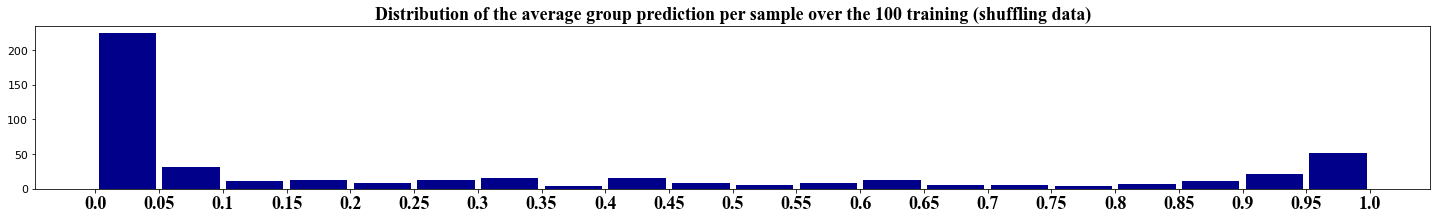

In [16]:
conslusiveness_score = performances_df.iloc[0]['y_pred']

fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 100 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

# Other

475 administrations left.


,id
diagnosis,
0.0,328
1.0,49
2.0,98


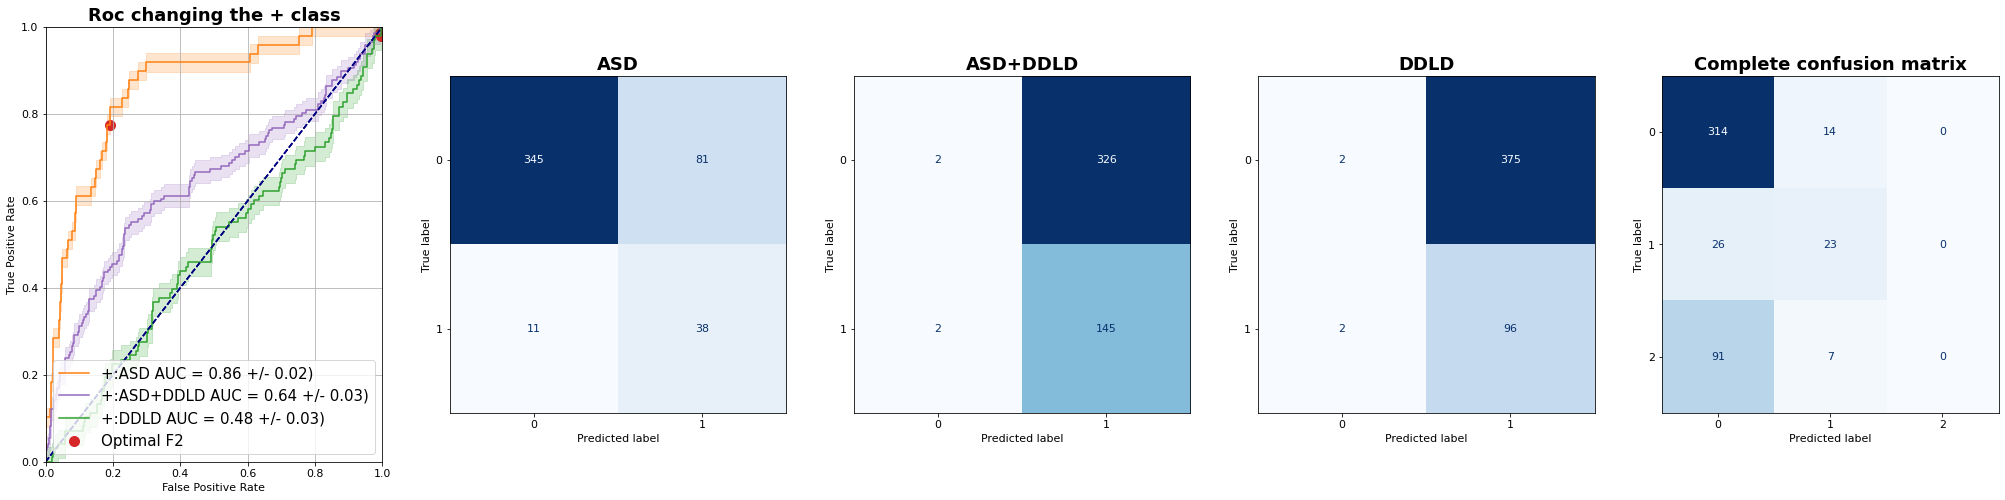

In [82]:
xgboost_hyperparameters = {'scale_pos_weight':False,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular_ddld', 
               #positive_class = [2],
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)
exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score)
exp.plot()